# Analisis y modelado de datos – Capa Gold

**Descripcion:**<br>
A partir de los *features* consolidados en la capa **Gold**, este notebook realiza un conjunto de análisis exploratorios y estadísticos para evaluar la calidad de los datos, comprender su comportamiento temporal y seleccionar las variables más informativas antes de entrenar un modelo de predicción de retornos a 5 días.<br>

**Objetivos**:<br>
- Cargar de manera eficiente los archivos Gold desde ADLS.<br>
- Verificar integridad temporal, valores nulos y duplicados.<br>
- Explorar distribuciones y estadísticas básicas de target y retornos.<br>
- Evaluar estacionariedad y autocorrelación para guiar técnicas de modelado temporal.<br>
- Medir correlaciones lineales y no lineales (MI) entre *features* y objetivo.<br>
- Detectar multicolinealidad (VIF) para evitar inestabilidad en los modelos.<br>

# 🗂️ Estructura de Carpetas del Proyecto `market/`

```plaintext
market/
├── raw/
│   ├── indices/
│   │   ├── SP500.parquet
│   │   ├── DJIA.parquet
│   │   ├── NASDAQ.parquet
│   │   ├── RUSSELL2000.parquet
│   │   └── WILSHIRE5000.parquet
│   └── macros/
│       ├── CPIAUCSL.parquet
│       ├── FEDFUNDS.parquet
│       ├── GDP.parquet
│       ├── GS10.parquet
│       ├── STLFSI2.parquet
│       └── UNRATE.parquet
│
├── bronze/
│   ├── indices/
│   │   └── SP500/
│   │       ├── year=1992/
│   │       │   └── SP500_1992.parquet
│   │       ├── year=1993/
│   │       │   └── SP500_1993.parquet
│   │       └── ...
│   └── macros/
│       └── CPIAUCSL/
│           ├── year=1992/
│           │   └── CPIAUCSL_1992.parquet
│           ├── year=1993/
│           │   └── CPIAUCSL_1993.parquet
│           └── ...
│
├── silver/
│   ├── indices_clean/
│   │   └── SP500/
│   │       ├── year=1992/
│   │       │   └── SP500_1992.parquet
│   │       ├── year=1993/
│   │       │   └── SP500_1993.parquet
│   │       └── ...
│   └── macros_clean/
│       └── CPIAUCSL/
│           ├── year=1992/
│           │   └── CPIAUCSL_1992.parquet
│           ├── year=1993/
│           │   └── CPIAUCSL_1993.parquet
│           └── ...
│
├── gold/
│   └── features/
│       ├── SP500/
│       │   ├── year=1992/
│       │   │   └── SP500_1992.parquet
│       │   └── ...
│       └── DJIA/
│           ├── year=1992/
│           │   └── DJIA_1992.parquet
│           └── ...
│
├── predictions/
│   ├── SP500/
│   │   ├── window=5d/
│   │   │   └── model=xgb_gbtree_v1/
│   │   │       ├── year=2022/
│   │   │       │   └── SP500_5d_xgb_gbtree_v1_2022.parquet
│   │   │       ├── year=2023/
│   │   │       │   └── SP500_5d_xgb_gbtree_v1_2023.parquet
│   │   │       └── ...
│   │   ├── window=20d/
│   │   │   └── model=xgb_gbtree_v1/
│   │   │       └── year=2022/...
│   │   └── window=180d/
│   │       └── model=xgb_gbtree_v1/
│   │           └── year=2022/...
│   └── DJIA/
│       └── window=5d/
│           └── model=rf_v2/
│               └── year=2024/...
│
├── metrics/
│   ├── SP500/
│   │   ├── window=5d/
│   │   │   └── model=xgb_gbtree_v1/
│   │   │       └── metrics.json
│   │   ├── window=20d/
│   │   │   └── model=xgb_gbtree_v1/
│   │   │       └── metrics.json
│   │   └── window=180d/
│   │       └── model=xgb_gbtree_v1/
│   │           └── metrics.json
│   └── DJIA/
│       └── window=5d/
│           └── model=rf_v2/
│               └── metrics.json
│
├── models/
│   ├── SP500/
│   │   ├── window=5d/
│   │   │   └── model=xgb_gbtree_v1/
│   │   │       └── SP500_5d_xgb_gbtree_v1.pkl
│   │   ├── window=20d/
│   │   │   └── model=xgb_gbtree_v1/
│   │   │       └── SP500_20d_xgb_gbtree_v1.pkl
│   │   └── window=180d/
│   │       └── model=xgb_gbtree_v1/
│   │           └── SP500_180d_xgb_gbtree_v1.pkl
│   └── DJIA/
│       └── window=5d/
│           └── model=rf_v2/
│               └── DJIA_5d_rf_v2.pkl
│
└── logs/
    ├── ingest_indices_2025-07-13.log
    └── ingest_macros_2025-07-13.log

## 1. Configuración básica, librerías y Parámetros globales del pipeline

In [1]:
# ================================================================
# 1.1 Configuración básica y librerías
# ================================================================
import os, datetime as dt, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from dotenv import load_dotenv
import adlfs, scipy.stats as st
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from utils_adls import _client, CONTAINER          # helpers propios

# Variables de entorno (cuenta & clave de Azure) --------------
load_dotenv()
ACCOUNT = os.getenv("AZ_STORAGE_ACCOUNT")
KEY = os.getenv("AZ_ACCOUNT_KEY")
GOLD_PREFIX = "gold/features"            # <ticker>/year=YYYY/…

# fsspec filesystem y cliente ADLS -----------------------------
fs  = adlfs.AzureBlobFileSystem(account_name=ACCOUNT, account_key=KEY)

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

## 2. Carga de datos Gold (Consolidado de Indices Bursatiles + Variables Macroeconomicas)

In [2]:
# ================================================================
# 2.1 Carga Gold Consolidado
# ================================================================
# Traer todas las particiones Gold para el ticker elegido y construir
# un DataFrame continuo ordenado por fecha.
# ----------------------------------------------------------------
TICKER = "DJIA"          # Utilizar ["SP500", "DJIA", "NASDAQ", "RUSSELL2000", "WILSHIRE5000"]

paths = fs.glob(f"{CONTAINER}/{GOLD_PREFIX}/{TICKER}/year=*/*.parquet")
df = pd.concat(pd.read_parquet(fs.open(p, "rb")) for p in paths).sort_values("date")

df.set_index("date", inplace=True)
target_col = f"y_{TICKER.lower()}_ret_5d"      # retorno a 5 días (objetivo)
print(f"Shape dataset {TICKER}: ", df.shape)

Shape dataset DJIA:  (12259, 43)


In [3]:
# ================================================================
# 2.2 Datos  y descripción de las columnas
# ================================================================
df.tail()

,ANFCI,BAA10Y,BAMLH0A0HYM2,CPIAUCSL,DCOILWTICO,DFII10,DGS10,DGS2,DTWEXBGS,FEDFUNDS,GDP,HOUST,ICSA,INDPRO,M2SL,NFCI,PAYEMS,PERMIT,STLFSI2,T10Y2Y,T10Y3M,T5YIE,TEDRATE,THREEFYTP10,UMCSENT,UNRATE,VIXCLS,WALCL,DJIA,DJIA_ret,djia_lag1,djia_lag5,djia_sma20,djia_sma50,djia_vol20,djia_rsi14,djia_std20,djia_bollinger_upper,djia_bollinger_lower,y_djia_ret_5d,y_djia_ret_20d,y_djia_ret_180d,year
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-07-21,-0.50697,1.73,2.89,321.5,68.39,1.98,4.38,3.85,120.7674,4.33,29962.047,1321.0,217000.0,104.0071,22020.8,-0.55311,159724.0,1393.0,-0.8509,0.53,-0.03,2.49,0.09,0.561,52.2,4.1,16.65,6659273.0,44323.070312,-0.000431,44342.191406,44254.781250,44462.049805,43458.797188,0.004646,47.919561,223.414983,44908.879771,44015.219839,NaN,NaN,NaN,2025
2025-07-22,-0.50697,1.73,2.90,321.5,68.39,1.96,4.35,3.83,120.7674,4.33,29962.047,1321.0,217000.0,104.0071,22020.8,-0.55311,159724.0,1393.0,-0.8509,0.52,-0.06,2.47,0.09,0.561,52.2,4.1,16.50,6659273.0,44502.441406,0.004047,44323.070312,44484.488281,44462.950781,43502.736406,0.004742,56.491707,223.546248,44910.043277,44015.858285,NaN,NaN,NaN,2025
2025-07-23,-0.50697,1.71,2.83,321.5,68.39,2.03,4.40,3.88,120.7674,4.33,29962.047,1321.0,217000.0,104.0071,22020.8,-0.55311,159724.0,1393.0,-0.8509,0.52,-0.01,2.44,0.09,0.561,52.2,4.1,15.37,6657715.0,45010.289062,0.011412,44502.441406,44342.191406,44472.038672,43552.549375,0.005108,61.969557,242.113924,44956.266521,43987.810823,NaN,NaN,NaN,2025
2025-07-24,-0.50697,1.68,2.82,321.5,68.39,1.98,4.43,3.91,120.7674,4.33,29962.047,1321.0,217000.0,104.0071,22020.8,-0.55311,159724.0,1393.0,-0.8509,0.52,0.01,2.50,0.09,0.561,52.2,4.1,15.39,6657715.0,44693.910156,-0.007029,45010.289062,44342.191406,44465.307617,43597.872812,0.005360,50.890378,233.395728,44932.099073,43998.516161,NaN,NaN,NaN,2025
2025-07-25,-0.50697,1.68,2.82,321.5,68.39,1.98,4.43,3.91,120.7674,4.33,29962.047,1321.0,217000.0,104.0071,22020.8,-0.55311,159724.0,1393.0,-0.8509,0.49,-0.02,2.47,0.09,0.561,52.2,4.1,15.39,6657715.0,44901.921875,0.004654,44693.910156,44342.191406,44468.977148,43649.516484,0.005466,61.243589,239.893512,44948.764172,43989.190125,NaN,NaN,NaN,2025


| **Columna**             | **Descripción**                                                                                         |
| ----------------------- | ------------------------------------------------------------------------------------------------------- |
| `date`                  | Fecha de la observación (formato día/mes/año).                                                          |
| `CPIAUCSL`              | Índice de Precios al Consumidor en EE.UU., mide la inflación.                                           |
| `FEDFUNDS`              | Tasa de fondos federales establecida por la Reserva Federal.                                            |
| `GDP`                   | Producto Interno Bruto (PIB) nominal de EE.UU.                                                          |
| `GS10`                  | Tasa de rendimiento de bonos del Tesoro a 10 años.                                                      |
| `STLFSI2`               | Índice de estrés financiero de St. Louis.                                                               |
| `UNRATE`                | Tasa de desempleo en EE.UU.                                                                             |
| `TICKER`                | Valor del activo financiero (dependiendo cual se filtre).                                               |
| `TICKER_ret`            | Retorno diario del activo financiero . Calculado como el cambio porcentual.                             |
| `TICKER_lag1`           | Precio del activo en el día anterior.                                                                   |
| `TICKER_lag5`           | Precio promedio o cierre del activo 5 días antes. Útil para capturar memoria del mercado.               |
| `TICKER_sma20`          | Media móvil simple de 20 días del activo. Ayuda a suavizar la tendencia a corto plazo.                  |
| `TICKER_sma50`          | Media móvil simple de 50 días. Detecta tendencias más largas.                                           |
| `TICKER_vol20`          | Volatilidad promedio de 20 días, mide la variación reciente del precio.                                 |
| `TICKER_rsi14`          | Índice de Fuerza Relativa (RSI) de 14 días. Oscilador que indica condiciones de sobrecompra/sobreventa. |
| `TICKER_std20`          | Desviación estándar de los precios en los últimos 20 días, mide la dispersión o volatilidad.            |
| `TICKER_bollinger_upper`| Banda superior de las Bandas de Bollinger (basadas en `sma20` + 2 desviaciones estándar).               |
| `TICKER_bollinger_lower`| Banda inferior de las Bandas de Bollinger (basadas en `sma20` - 2 desviaciones estándar).               |
| `y_TICKER_ret_5d`       | Retorno futuro del activo en 5 días. Etiqueta usada en modelos de predicción a corto plazo.             |
| `y_TICKER_ret_20d`      | Retorno futuro en 20 días. Objetivo para predicción a mediano plazo.                                    |
| `y_TICKER_ret_180d`     | Retorno futuro en 180 días. Utilizado para predicciones a largo plazo.                                  |
| `year`                  | Año de la observación (extraído de la columna `date`).                                                  |

## 3. Resumen de calidad de datos y estadística básica

In [4]:
# ================================================================
# 3.1 Calidad de datos
# ================================================================
# Identificar valores nulos, fechas duplicadas o problemas de rango
# que puedan sesgar las métricas del modelo.
# ----------------------------------------------------------------
print(df.isna().mean().sort_values(ascending=False).head(20))

print("\nRango fechas:", df.index.min().date(), "→", df.index.max().date())
assert df.index.is_monotonic_increasing and df.index.freq is None

y_djia_ret_180d         0.014683
djia_sma50              0.003997
djia_vol20              0.001631
y_djia_ret_20d          0.001631
djia_std20              0.001550
djia_sma20              0.001550
djia_bollinger_lower    0.001550
djia_bollinger_upper    0.001550
djia_rsi14              0.001142
djia_lag5               0.000408
y_djia_ret_5d           0.000408
djia_lag1               0.000082
DJIA_ret                0.000082
DTWEXBGS                0.000000
FEDFUNDS                0.000000
GDP                     0.000000
DFII10                  0.000000
DCOILWTICO              0.000000
CPIAUCSL                0.000000
BAMLH0A0HYM2            0.000000
dtype: float64

Rango fechas: 1992-01-02 → 2025-07-25


,count,mean,std,min,1%,5%,50%,95%,99%,max
ANFCI,12259.0,-3.627331e-01,6.118729e-01,-1.226120,-1.119660,-0.911280,-4.969100e-01,7.470100e-01,2.791590e+00,3.845640e+00
BAA10Y,12259.0,2.324480e+00,7.259504e-01,1.220000,1.400000,1.500000,2.190000e+00,3.380000e+00,5.524200e+00,6.160000e+00
BAMLH0A0HYM2,12259.0,4.934566e+00,2.463353e+00,2.410000,2.590000,2.880000,4.150000e+00,9.000000e+00,1.661520e+01,2.182000e+01
CPIAUCSL,12259.0,2.133427e+02,4.826494e+01,138.300000,139.700000,145.000000,2.134480e+02,3.080870e+02,3.176030e+02,3.215000e+02
DCOILWTICO,12259.0,5.309536e+01,2.918550e+01,-36.980000,13.060000,16.659000,5.154000e+01,1.027030e+02,1.165600e+02,1.453100e+02
DFII10,12259.0,1.439346e+00,1.078284e+00,-1.190000,-1.020000,-0.720000,1.830000e+00,2.430000e+00,2.560000e+00,3.150000e+00
DGS10,12259.0,4.016048e+00,1.741190e+00,0.520000,0.690000,1.540000,4.050000e+00,6.930000e+00,7.640000e+00,8.050000e+00
DGS2,12259.0,2.994258e+00,2.098407e+00,0.090000,0.140000,0.230000,2.830000e+00,6.240000e+00,6.900000e+00,7.740000e+00
DTWEXBGS,12259.0,1.039545e+02,9.630403e+00,85.469200,86.636900,90.135000,1.014155e+02,1.223278e+02,1.272196e+02,1.302142e+02
FEDFUNDS,12259.0,2.626840e+00,2.176867e+00,0.050000,0.070000,0.080000,2.270000e+00,5.740000e+00,6.510000e+00,6.540000e+00


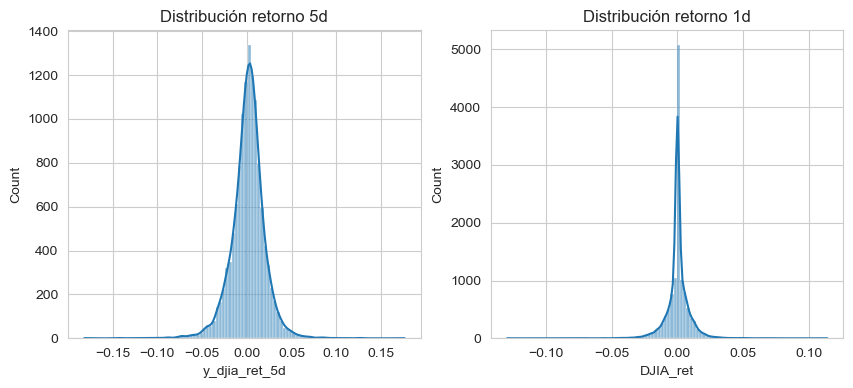

In [5]:
# ================================================================
# 3.2 Estadísticos básicos y distribución
# ================================================================
# entender la dispersión, asimetría y colas de las variables clave
# para anticipar necesidades de escalado o transformación.
# ----------------------------------------------------------------
display(df.describe(percentiles=[.01,.05,.5,.95,.99]).T)

# distribuciones rápidas de target y retornos diarios
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(df[target_col].dropna(), bins=100, kde=True, ax=ax[0])
ax[0].set_title("Distribución retorno 5d")

sns.histplot(df[f"{TICKER}_ret"].dropna(), bins=100, kde=True, ax=ax[1])
ax[1].set_title("Distribución retorno 1d")

plt.show()

## 4. Tests de estacionariedad y autocorrelación

In [6]:
# ================================================================
# 4.1 Tests de estacionariedad
# ================================================================
# Verificar si las series (retornos y log‑precios) son estacionarias.
# Esto ayuda a decidir si se requieren diferenciaciones o modelos
# que asuman estacionariedad (ARIMA, etc.).
# ----------------------------------------------------------------
def adf_test(series, title="ADF"):
    result = adfuller(series.dropna(), autolag="AIC")
    print(f"{title}: ADF={result[0]:.3f}  p={result[1]:.3g}")

adf_test(df[f"{TICKER}_ret"],        "RET 1d")
adf_test(df[target_col],             "RET 5d target")
adf_test(np.log(df[TICKER]),         "Log-price")

RET 1d: ADF=-22.604  p=0
RET 5d target: ADF=-16.963  p=9.28e-30
Log-price: ADF=-0.845  p=0.806


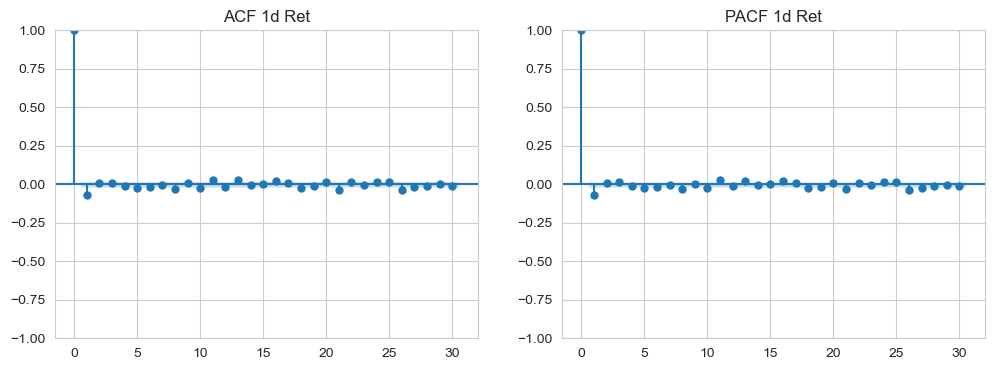

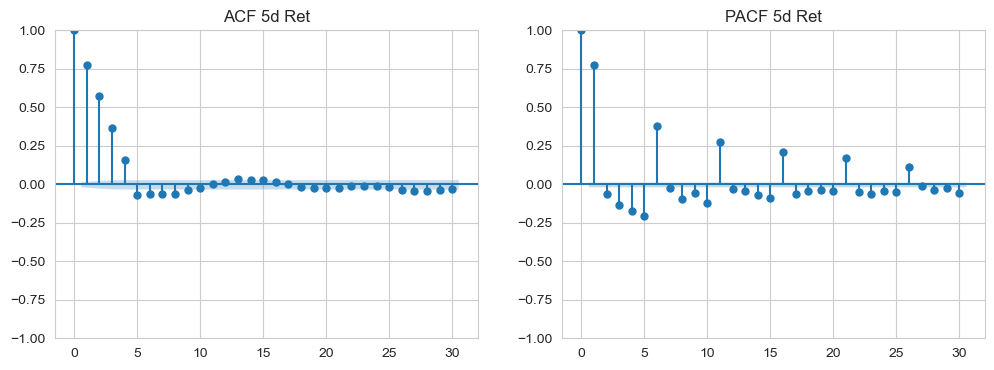

In [7]:
# ================================================================
# 4.2 Autocorrelación (ACF / PACF)
# ================================================================
# Detectar patrones de dependencia temporal que puedan explotarse con
# modelos AR, o bien confirmar la ausencia de autocorrelación.
# ----------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df[f"{TICKER}_ret"].dropna(), lags=30, ax=ax[0])
plot_pacf(df[f"{TICKER}_ret"].dropna(), lags=30, ax=ax[1])
ax[0].set_title("ACF 1d Ret")
ax[1].set_title("PACF 1d Ret")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df[target_col].dropna(), lags=30, ax=ax[0])
plot_pacf(df[target_col].dropna(), lags=30, ax=ax[1])
ax[0].set_title("ACF 5d Ret")
ax[1].set_title("PACF 5d Ret")
plt.show()

## 5. Tests de estacionariedad y autocorrelación

Top correlaciones (absolutas) con el objetivo:


y_djia_ret_5d      1.000000
y_djia_ret_20d     0.504188
y_djia_ret_180d    0.178488
ICSA               0.072434
VIXCLS             0.047171
DJIA_ret          -0.039796
NFCI              -0.037401
UNRATE             0.036333
DCOILWTICO        -0.034487
ANFCI             -0.033184
djia_vol20         0.029697
djia_rsi14        -0.027703
T10Y3M            -0.025666
djia_std20         0.024374
T5YIE             -0.023701
Name: y_djia_ret_5d, dtype: float64

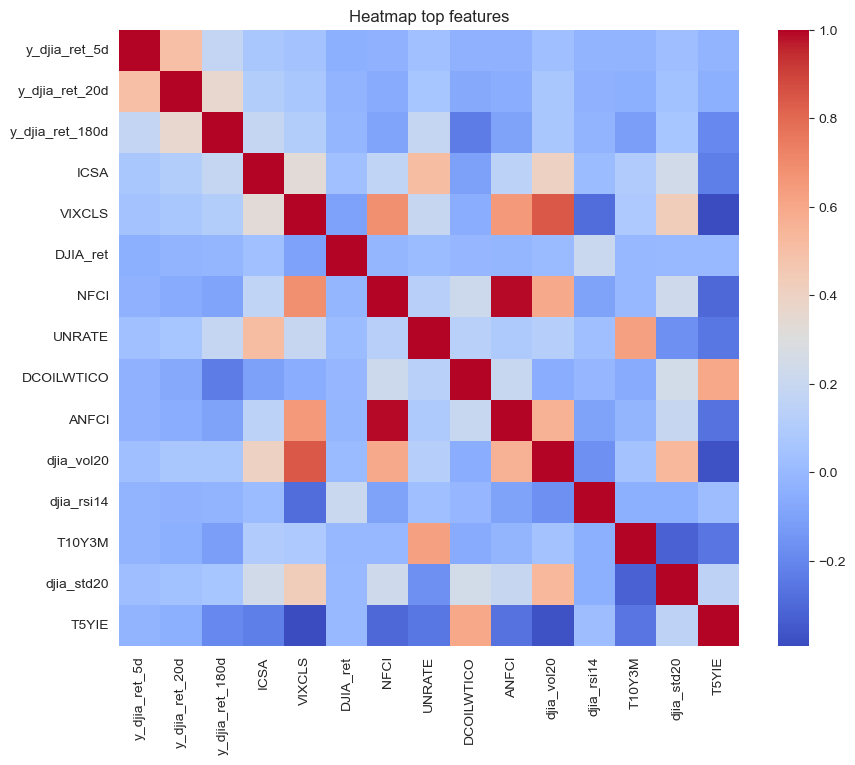

In [8]:
# ================================================================
# 4.2 Correlación Líneal con el objetivo
# ================================================================
# Identificar rápidamente variables con alta correlación (positiva o
# negativa) respecto al target; útil para descartar irrelevantes.
# ----------------------------------------------------------------

num_cols = df.select_dtypes(np.number).columns
corr_target = df[num_cols].corr()[target_col].sort_values(ascending=False)

print("Top correlaciones (absolutas) con el objetivo:")
display(corr_target.reindex(corr_target.abs().sort_values(ascending=False).index).head(15))

# Mapa de calor de un subconjunto
top_feats = corr_target.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10,8))
sns.heatmap(df[top_feats].corr(), annot=False, cmap="coolwarm")
plt.title("Heatmap top features")
plt.show()

## 6. Relación no linieal y grupos de variables altamente correlacionadas

In [9]:
# ================================================================
# 6.1 Importancia basada en mutual information
# ================================================================
# Capturar relaciones no lineales entre variables numéricas y el
# objetivo; complementa la correlación lineal..
# ----------------------------------------------------------------

X = df[num_cols].drop(columns=[target_col]).dropna()
y = df.loc[X.index, target_col]

mi = mutual_info_regression(X, y, random_state=0)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("\nTop 15 features por Mutual Information:")
print(mi_series.head(15))


Top 15 features por Mutual Information:
y_djia_ret_20d    0.196999
VIXCLS            0.150079
CPIAUCSL          0.125183
DJIA              0.121758
M2SL              0.120671
GDP               0.116688
djia_sma50        0.115587
djia_vol20        0.110417
INDPRO            0.110301
PAYEMS            0.109387
NFCI              0.108086
djia_sma20        0.106388
djia_lag1         0.106284
STLFSI2           0.105943
year              0.104657
dtype: float64


# Entrenamiento de modelos de Regresion Machine Learning

## 7.1  HistGradientBoostingRegressor con Optimización de Hiperparámetros y Selección de Variables por Ventana Temporal

### 7.1.1 Selector de columnas

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance

WINDOWS = [5, 20, 180]
# --- utilidades ---
def _horizon_from_target(col: str) -> int:
    import re
    m = re.search(r"_ret_(\d+)d$", col)
    return int(m.group(1)) if m else 0

def time_series_cv_with_gap(n_samples: int, n_splits: int, gap: int):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for tr, te in tscv.split(np.arange(n_samples)):
        if gap > 0:
            tr = tr[: max(0, len(tr) - gap)]
            te = te[gap:] if len(te) > gap else np.array([], dtype=int)
        if len(tr) and len(te):
            yield tr, te

def build_Xy_for_target(df, target, split_date=None, extra_drop=None):
    drop_cols = [t for t in [f"y_{TICKER.lower()}_ret_{w}d" for w in WINDOWS] if t != target]
    if extra_drop: drop_cols += list(extra_drop)
    X = df.drop(columns=drop_cols + [target]).select_dtypes(include=[np.number]).replace([np.inf,-np.inf], np.nan)
    y = df[target].copy()
    valid = ~y.isna()
    X, y = X.loc[valid], y.loc[valid]
    X = X.sort_index(); y = y.sort_index()
    # imputación simple sin fuga (recomendado)
    X = X.ffill().fillna(X.median())
    return X, y

def permutation_importance_oos(df, target, n_splits=5):
    X, y = build_Xy_for_target(df, target)
    feat_names = X.columns.tolist()
    gap = _horizon_from_target(target)

    model = HistGradientBoostingRegressor(
        loss="absolute_error" if target.endswith("5d") or target.endswith("20d") else "squared_error",
        early_stopping=True, validation_fraction=0.1, n_iter_no_change=50, random_state=42
    )

    imp_mat = []
    freq_nonzero = np.zeros(len(feat_names), dtype=int)

    for fold, (tr, te) in enumerate(time_series_cv_with_gap(len(y), n_splits=n_splits, gap=gap), 1):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        model.fit(Xtr, ytr)
        # importancia por permutación evaluada SOLO en test (OOS)
        pi = permutation_importance(model, Xte, yte, n_repeats=10, random_state=42, n_jobs=-1)
        imp_mat.append(pi.importances_mean)
        freq_nonzero += (pi.importances_mean > 0).astype(int)

    imp_mat = np.vstack(imp_mat) if imp_mat else np.zeros((0, len(feat_names)))
    imp_mean = imp_mat.mean(axis=0) if imp_mat.size else np.zeros(len(feat_names))
    imp_std  = imp_mat.std(axis=0)  if imp_mat.size else np.zeros(len(feat_names))
    stability = freq_nonzero / max(1, len(imp_mat))

    rank_df = (pd.DataFrame({
        "feature": feat_names,
        "imp_mean": imp_mean,
        "imp_std": imp_std,
        "stability": stability
    }).sort_values(["imp_mean","stability"], ascending=[False, False]).reset_index(drop=True))

    return rank_df

rank_5d  = permutation_importance_oos(df, f"y_{TICKER.lower()}_ret_5d",  n_splits=5)
rank_20d = permutation_importance_oos(df, f"y_{TICKER.lower()}_ret_20d", n_splits=5)
rank_180d= permutation_importance_oos(df, f"y_{TICKER.lower()}_ret_180d",n_splits=5)

display(rank_5d.head(20))
display(rank_20d.head(20))
display(rank_180d.head(20))

,feature,imp_mean,imp_std,stability
0,djia_sma20,0.005303,0.016380,0.4
1,T10Y2Y,0.005239,0.009600,0.6
2,BAA10Y,0.003416,0.010982,0.6
3,djia_vol20,0.002632,0.015361,0.6
4,UNRATE,0.001796,0.003133,0.8
5,djia_rsi14,0.001597,0.007673,0.4
6,ANFCI,0.001280,0.004415,0.6
7,CPIAUCSL,0.000977,0.001229,0.4
8,ICSA,0.000728,0.026465,0.6
9,HOUST,0.000476,0.000438,0.6


,feature,imp_mean,imp_std,stability
0,UMCSENT,0.037408,0.055393,0.8
1,THREEFYTP10,0.010162,0.022484,0.6
2,djia_lag5,0.008096,0.018954,0.4
3,djia_std20,0.007517,0.012918,0.6
4,BAMLH0A0HYM2,0.004340,0.010585,0.6
5,DCOILWTICO,0.003222,0.007911,0.6
6,djia_rsi14,0.002064,0.007220,0.6
7,GDP,0.000448,0.000895,0.4
8,CPIAUCSL,0.000405,0.000809,0.2
9,INDPRO,0.000208,0.017784,0.4


,feature,imp_mean,imp_std,stability
0,djia_sma50,0.067209,0.105091,0.4
1,INDPRO,0.043049,0.088012,0.4
2,STLFSI2,0.030968,0.055464,1.0
3,PAYEMS,0.016204,0.028251,0.6
4,ANFCI,0.015960,0.095928,0.6
5,T10Y3M,0.014752,0.021069,0.8
6,VIXCLS,0.014677,0.027035,0.8
7,djia_rsi14,0.010119,0.013738,0.8
8,DGS2,0.007687,0.016370,0.4
9,THREEFYTP10,0.007236,0.007194,0.8


Importancia OOS con CV temporal + “gap” = horizonte
– Tu función hace CV de series de tiempo y calcula permutation importance en el fold de test (fuera de muestra).
– Agregamos por fold → imp_mean, imp_std y estabilidad (proporción de folds con importancia > 0).

Regla de selección por horizonte
Para cada ventana (5d, 20d, 180d) prioricé:

imp_mean > 0 y estabilidad ≥ 0.6 (o cercano, si la señal tiene fuerte sentido económico).

Evité señales con imp_mean negativo (tendían a empeorar).

Si hay pares colineales (niveles vs spreads), preferí la variable con narrativa más clara para ese plazo (p.ej., slope T10Y3M mejor que niveles redundantes).

Mantuve algunos técnicos del índice que salieron de forma recurrente (volatilidad/dispersiones), porque ayudan a capturar la magnitud a corto plazo.

Ajuste por frecuencia económica

Corto plazo (5d): señales diarias/semanales y risk‑on/off (VIX, oil, slope, claims), + técnicos.

Medio (20d): señales mensuales/sentiment/inflation expectations (UMCSENT, T5YIE, oil, slope), + técnicos.

Largo (180d): señales cíclicas/financiamiento/estrés (spreads HY/BAA, tasas largas, VIX, FSI), + un “ancla” técnica.

2) Mapeo con tus tablas (lo que vi en tus capturas)
5 días (tabla 1):

Positivos y/o estables: ICSA (0.8), T10Y3M (0.6), sp500_vol20 (0.6), CPIAUCSL (0.6), HOUST (0.8), PAYEMS (0.6), DCOILWTICO (0.6).

Técnicos que aparecen: sp500_rsi14, sp500_sma50 (pero los moving average levels muchas veces capturan lo mismo que rsi/vol/std).

Negativos / poco útiles: SP500 (nivel), SP500_ret (ruido contemporáneo), algunos niveles macro con imp ~0.

➡️ Por eso propuse para 5d:
ICSA, T10Y3M, DCOILWTICO, VIXCLS (risk‑off diario), más técnicos robustos del propio índice: std20, vol20, rsi14.
Y mantuve ingenierías que ya te rendían bien: bollinger_width, vol_std_ratio.

20 días (tabla 2):

Arriba: sp500_std20, PAYEMS, HOUST, INDPRO, UMCSENT, PERMIT, T10Y3M, DCOILWTICO, T5YIE.

SP500_ret y WALCL salieron negativos en media; UNRATE bajo y poco estable.

➡️ Para 20d prioricé el slope T10Y3M, sentimiento UMCSENT, expectativa de inflación T5YIE y oil DCOILWTICO (drivers suaves en 1 mes), + los técnicos (std20, vol20, rsi14) y las ingenierías.

Nota: Si en tus pruebas ves que PAYEMS/HOUST/INDPRO ayudan a 20d (aparecen arriba), agrégalas sin problema; yo partí con un set compacto para evitar sobreajuste y colinealidades fuertes.

180 días (tabla 3):

Top claros y estables: BAMLH0A0HYM2 (HY spread), DGS10 (10Y), BAA10Y (spread crédito IG), VIXCLS, STLFSI2 (estrés), DCOILWTICO, T10Y3M.

Técnicos que sobreviven: sp500_rsi14; bollinger_upper/lower aparecen pero suelen redundar → los compacté en bollinger_width.

Muchos niveles macro salen ~0 en 6M (su señal es débil o ya va por spreads).

➡️ Para 180d elegí spreads/estrés/tasas: BAMLH0A0HYM2, BAA10Y, DGS10, T10Y3M, VIXCLS, STLFSI2, DCOILWTICO + una base técnica (std20, vol20) y bollinger_width, vol_std_ratio.

3) Por qué no puse algunos que salen bien rankeados
SP500 (nivel) y SP500_ret contemporáneo: tienden a salir con imp_mean ≤ 0; suelen introducir leakage o ruido y empeoran la generalización.

Muchos niveles macro (p.ej., M2SL, year) muestran imp ~0: no suman OOS.

Promedios móviles del precio (sma20/50) duplican parte de lo que ya llevan std/vol/rsi → prefiero no sobrecargar con colineales.

4) ¿Por qué mantener bollinger_width / vol_std_ratio si no aparecen en el ranking?
Son features de ingeniería que ya viste que te ayudan en HGBR (mejoran ligeramente magnitud/DA). Aunque su PI no quede “top”, al ser baratas y poco colineales, vale la pena mantenerlas mientras no degraden OOS.

### 7.1.2 Entrenamiento

 ### Ventana de 5, 20 y 180 días

In [11]:
# ================================================================
# 7.1.1 Importar Librerias necesarias
# ================================================================
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [12]:
# ================================================================
# 7.1.2 Almacenar resultados para cada ventana
# ================================================================

results = {}

targets = [f"y_{TICKER.lower()}_ret_5d",
           f"y_{TICKER.lower()}_ret_20d",
           f"y_{TICKER.lower()}_ret_180d"]
drop_cols_template = set(targets)

# Mapeo de pérdida por horizonte (robusta en corto plazo)
LOSS_BY_TARGET = {
    f"y_{TICKER.lower()}_ret_5d":  "absolute_error",
    f"y_{TICKER.lower()}_ret_20d": "absolute_error",
    f"y_{TICKER.lower()}_ret_180d":"squared_error",
}

# -------------------------
# Listas de features por ventana (macro/tecnicos)
# (se intersectan con X; si falta alguna no rompe)
# -------------------------
FEATS_BY_H = {
    5:  [
        "ICSA","T10Y3M","DCOILWTICO","VIXCLS",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
        # "djia_bollinger_upper",  # si existe y quieres incluirla
    ],
    20: [
        "T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
        # "djia_bollinger_upper",
    ],
    180:[
        "BAMLH0A0HYM2","BAA10Y","DGS10","T10Y3M","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", 
        "bollinger_width","vol_std_ratio",
        # "djia_bollinger_upper",
    ],
}

## Para metricas
def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float((np.sign(y_true) == np.sign(y_pred)).mean())

def sign_confusion_counts(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    tp = int(((y_true > 0)  & (y_pred > 0)).sum())
    tn = int(((y_true <= 0) & (y_pred <= 0)).sum())
    fp = int(((y_true <= 0) & (y_pred > 0)).sum())
    fn = int(((y_true > 0)  & (y_pred <= 0)).sum())
    pos_total = tp + fn
    pos_hit_rate = float(tp / pos_total) if pos_total > 0 else np.nan
    neg_hit_rate = float(tn / (tn + fp)) if (tn + fp) > 0 else np.nan
    return tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate



In [13]:
# ================================================================
# 7.1.3 Entrenamiento con Histogram-based Gradient Boosting Regressor
# ================================================================
for target in targets:
    print(f"\n🔄 Entrenando modelo para: {target}\n{'-'*50}")
    
    # --- 1) Selección de columnas y target ---
    drop_cols = list(drop_cols_template - {target})
    X = df.drop(columns=drop_cols + [target]).copy()
    y = df[target].copy()

    # --- 2) Feature engineering barato y seguro ---
    up   = f'{TICKER.lower()}_bollinger_upper'
    lo   = f'{TICKER.lower()}_bollinger_lower'
    vol20 = f'{TICKER.lower()}_vol20'
    std20 = f'{TICKER.lower()}_std20'
    # Señales básicas que suelen ayudar
    if all(col in X.columns for col in [up, lo]):
        X['bollinger_width'] = X[up] - X[lo]
    if all(col in X.columns for col in [vol20, std20]):
        X['vol_std_ratio'] = X[vol20] / (X[std20] + 1e-6)

    # Lags de retornos del ticker si existen (se crean aquí para poder seleccionarlos después)
    lag_cols = [c for c in X.columns if c.startswith(f"{TICKER.lower()}_ret_")]
    for k in [1, 5, 20, 60, 120]:
        for c in lag_cols:
            lag_name = f"{c}_lag{k}"
            if lag_name not in X.columns:
                X[lag_name] = X[c].shift(k)

    # --- 2.1 Selección personalizada por ventana ---
    # Detecta el horizonte del target (5/20/180) y arma la lista permitida
    horizon = int(target.rsplit('_', 1)[-1].replace('d',''))  # obtiene 5,20,180
    base_allowed = [c for c in FEATS_BY_H.get(horizon, []) if c in X.columns]

    # Incluye lags dinámicos del índice según horizonte
    if horizon == 5:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(1|5|20)$"
    elif horizon == 20:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(5|20)$"
    else:  # 180d
        pat = rf"^{TICKER.lower()}_ret_.*_lag(60|120)$"

    dyn_lags = [c for c in X.columns if re.match(pat, c)]
    allowed = list(dict.fromkeys(base_allowed + dyn_lags))  # sin duplicados

    # Si hay lista permitida, filtra X; si no, se queda con todo lo numérico
    # (Esto mantiene tu estructura original, solo que con filtro cuando aplica)
    # Sólo numéricas
    X = X.select_dtypes(include=[np.number])
    if len(allowed) > 0:
        allowed = [c for c in allowed if c in X.columns]
        if len(allowed) > 0:
            X = X[allowed].copy()

    # --- 3) Filtrar filas con target disponible ---
    valid_idx = ~y.isna()
    X, y = X.loc[valid_idx], y.loc[valid_idx]

    # --- 4) Split temporal por índice ---
    split_date = '2022-01-01'
    X_train = X[X.index < split_date].copy()
    X_test  = X[X.index >= split_date].copy()
    y_train = y[y.index < split_date].copy()
    y_test  = y[y.index >= split_date].copy()

    # --- 5) Imputación simple (igual a tu estructura) ---
    X_train.ffill(inplace=True); X_train.bfill(inplace=True)
    X_test.ffill(inplace=True);  X_test.bfill(inplace=True)

    # No escalamos (HGBR no lo requiere)
    X_train_np = X_train.values
    X_test_np  = X_test.values

    # --- 6) Estimador base con early stopping ---
    base_loss = LOSS_BY_TARGET.get(target, "squared_error")
    base_model = HistGradientBoostingRegressor(
        loss=base_loss,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=50,
        random_state=42
    )

    # Búsqueda aleatoria: más capacidad y algo de regularización
    param_grid = {
        'max_iter': [600, 900, 1200, 1500],
        'learning_rate': [0.02, 0.05, 0.08, 0.1],
        'max_depth': [3, 4, 5, 6],
        'l2_regularization': [0.0, 0.1, 0.5, 1.0],
        'min_samples_leaf': [10, 20, 40, 80],
        # 'max_bins': [255, 511],  # opcional, según versión de sklearn
    }

    tscv = TimeSeriesSplit(n_splits=5)

    search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    search.fit(X_train_np, y_train)
    best_model = search.best_estimator_

    # --- 7) Evaluación en Test ---
    y_pred = best_model.predict(X_test_np)
    
    mse  = float(mean_squared_error(y_test, y_pred))
    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_test, y_pred))
    r2   = float(r2_score(y_test, y_pred)) if np.isfinite(np.var(y_pred)) and np.isfinite(np.var(y_test)) else np.nan
    da   = directional_accuracy(y_test.values, y_pred)
    tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate = sign_confusion_counts(y_test.values, y_pred)
    
    print(
        f"✅ {target} | RMSE: {rmse:.6f} | MSE: {mse:.6f} | MAE: {mae:.6f} | "
        f"R²: {r2:.3f} | DA: {da:.3f} | PosHit: {pos_hit_rate:.3f} ({tp}/{pos_total})"
        f"| NegHit: {neg_hit_rate:.3f} ({tn}/{tn+fp})"
    )

    # --- 8) Guardar resultados para graficar ---
    results[target] = {
        'ticker': TICKER,
        'model': best_model,
        "tipoModel": "Regresión",
        'scaler': None,
        'features_used': X.columns.tolist(),
        'y_test': y_test,
        'y_pred': pd.Series(y_pred, index=y_test.index),
        'rmse': rmse,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'da': da,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'pos_total': pos_total,
        'pos_hit_rate': pos_hit_rate,
        'neg_hit_rate': neg_hit_rate
    }


🔄 Entrenando modelo para: y_djia_ret_5d
--------------------------------------------------
✅ y_djia_ret_5d | RMSE: 0.019177 | MSE: 0.000368 | MAE: 0.014372 | R²: -0.077 | DA: 0.552 | PosHit: 0.869 (616/709)| NegHit: 0.170 (100/588)

🔄 Entrenando modelo para: y_djia_ret_20d
--------------------------------------------------
✅ y_djia_ret_20d | RMSE: 0.039307 | MSE: 0.001545 | MAE: 0.030705 | R²: -0.234 | DA: 0.529 | PosHit: 0.772 (573/742)| NegHit: 0.194 (105/540)

🔄 Entrenando modelo para: y_djia_ret_180d
--------------------------------------------------
✅ y_djia_ret_180d | RMSE: 0.079621 | MSE: 0.006340 | MAE: 0.064771 | R²: -0.206 | DA: 0.722 | PosHit: 0.916 (757/826)| NegHit: 0.179 (53/296)


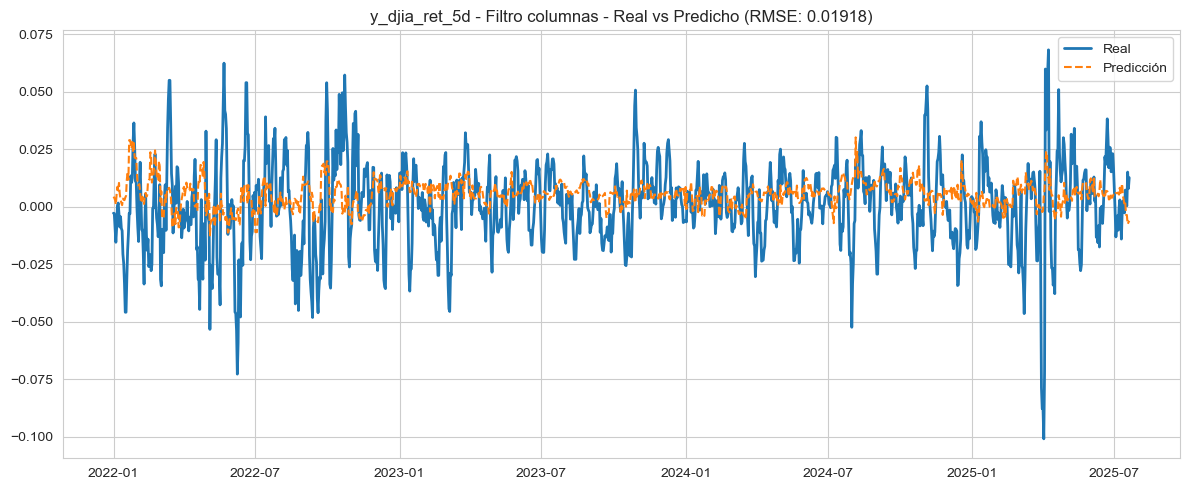

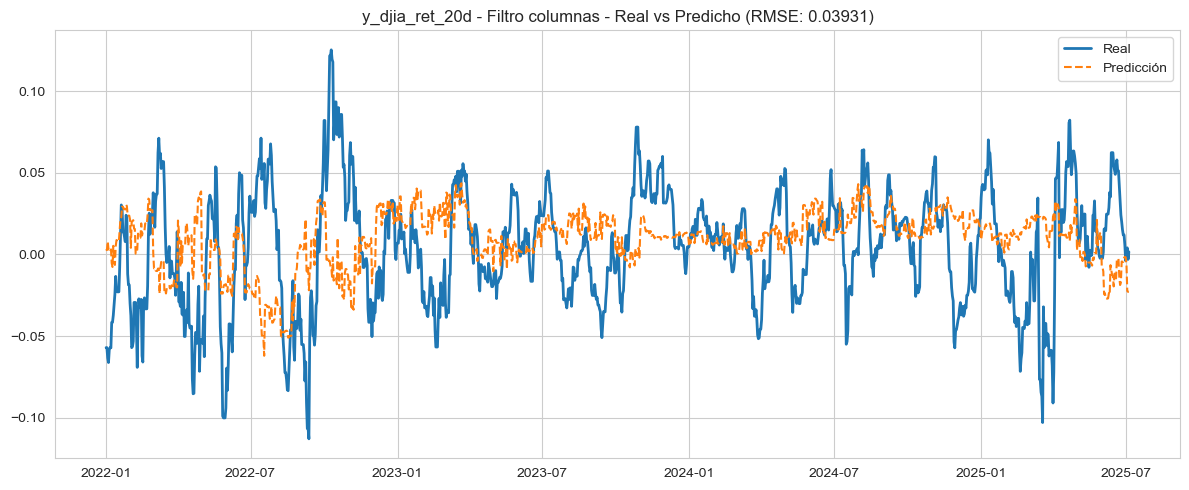

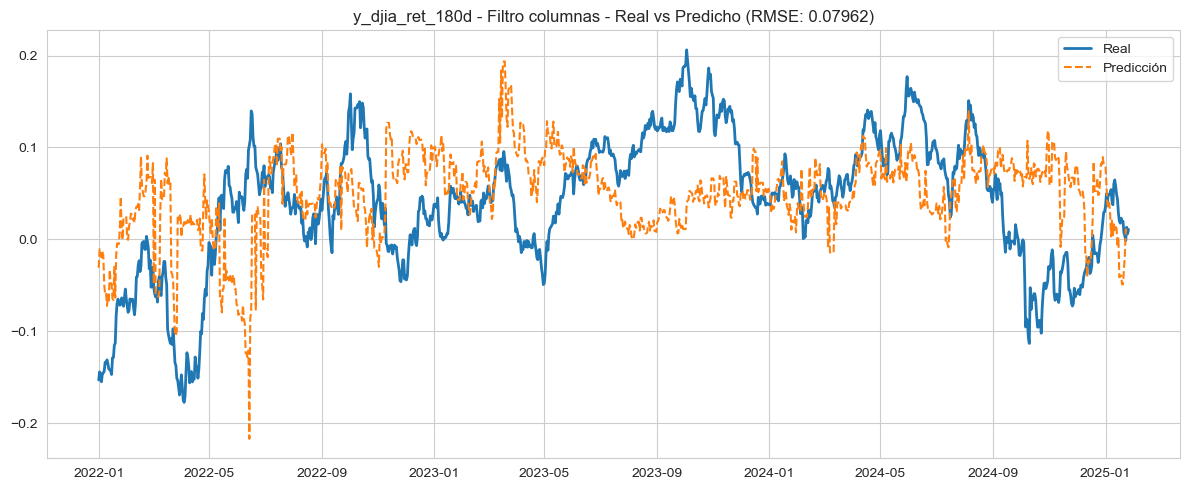

In [14]:
import matplotlib.pyplot as plt

for target, data in results.items():
    y_test = data['y_test']
    y_pred = data['y_pred']
    rmse = data['rmse']

    plt.figure(figsize=(12, 5))
    plt.plot(y_test.index, y_test, label='Real', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicción', linestyle='--')
    plt.title(f'{target} - Filtro columnas - Real vs Predicho (RMSE: {rmse:.5f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 7.1.3 Guardar Modelo en Azure Data Lake

In [15]:
# ================================================================
# Guardar solo los modelos entrenados (.pkl) en Azure Data Lake
# ================================================================
import joblib

MODEL_FAMILY = "hgb_opt_featbywindow_reg_v1"   # Personaliza según versión/modelo

for target, d in results.items():
    window = target.split("_")[-1]  # Extrae '5d', '20d', etc.
    model = d["model"]

    mdl_dir  = f"{CONTAINER}/models/{TICKER}/window={window}/model={MODEL_FAMILY}"
    mdl_path = f"{mdl_dir}/{TICKER}_{window}_{MODEL_FAMILY}.pkl"

    if not fs.exists(mdl_dir):
        fs.makedirs(mdl_dir, exist_ok=True)

    with fs.open(mdl_path, "wb") as f:
        joblib.dump(d, f)

    print(f"✔ Modelo guardado: {mdl_path}")

✔ Modelo guardado: market/models/DJIA/window=5d/model=hgb_opt_featbywindow_reg_v1/DJIA_5d_hgb_opt_featbywindow_reg_v1.pkl
✔ Modelo guardado: market/models/DJIA/window=20d/model=hgb_opt_featbywindow_reg_v1/DJIA_20d_hgb_opt_featbywindow_reg_v1.pkl
✔ Modelo guardado: market/models/DJIA/window=180d/model=hgb_opt_featbywindow_reg_v1/DJIA_180d_hgb_opt_featbywindow_reg_v1.pkl


## 7.2 Modelo LSTM (pytorch) para regresión

### 7.2.1 Selector de columnas

In [16]:
# ================================================================
# Permutation Importance OOS para una LSTM (PyTorch) - Selección de columnas
# ================================================================
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

WINDOWS = [5, 20, 180]

# ---------- Modelo LSTM (igual al tuyo) ----------
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# ---------- Utilidades base ----------
def _horizon_from_target(col: str) -> int:
    m = re.search(r"_ret_(\d+)d$", col)
    return int(m.group(1)) if m else 0

def time_series_cv_with_gap(n_samples: int, n_splits: int, gap: int):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for tr, te in tscv.split(np.arange(n_samples)):
        if gap > 0:
            tr = tr[: max(0, len(tr) - gap)]
            te = te[gap:] if len(te) > gap else np.array([], dtype=int)
        if len(tr) and len(te):
            yield tr, te

def _make_engineering(X: pd.DataFrame, ticker: str) -> pd.DataFrame:
    up   = f"{ticker}_bollinger_upper"
    lo   = f"{ticker}_bollinger_lower"
    vol20= f"{ticker}_vol20"
    std20= f"{ticker}_std20"
    X = X.copy()
    if all(c in X.columns for c in [up, lo]):
        X["bollinger_width"] = X[up] - X[lo]
    if all(c in X.columns for c in [vol20, std20]):
        X["vol_std_ratio"]   = X[vol20] / (X[std20] + 1e-6)
    return X

def _add_lags(X: pd.DataFrame, ticker: str, ks=(1,5,20,60,120)) -> pd.DataFrame:
    X = X.copy()
    lag_cols = [c for c in X.columns if c.startswith(f"{ticker}_ret_")]
    for k in ks:
        for c in lag_cols:
            name = f"{c}_lag{k}"
            if name not in X.columns:
                X[name] = X[c].shift(k)
    return X

def _allowed_lags_by_horizon(ticker: str, horizon: int):
    if horizon == 5:
        pat = rf"^{ticker}_ret_.*_lag(1|5|20)$"
    elif horizon == 20:
        pat = rf"^{ticker}_ret_.*_lag(5|20)$"
    else:
        pat = rf"^{ticker}_ret_.*_lag(60|120)$"
    return pat

def build_Xy_for_target_seq(df: pd.DataFrame, target: str, ticker: str,
                            allow_feats: list[str] | None = None) -> tuple[pd.DataFrame, pd.Series]:
    """Construye X,y con ingeniería + lags; filtra NaNs y aplica imputación sin fuga."""
    drop_cols = [t for t in [f"y_{ticker}_ret_{w}d" for w in WINDOWS] if t != target]
    X = df.drop(columns=drop_cols + [target]).copy()
    y = df[target].copy()

    # ingeniería + lags
    X = _make_engineering(X, ticker)
    X = _add_lags(X, ticker)

    # si se pasa allowlist (p.ej., de una prueba previa), intersecta
    X = X.select_dtypes(include=[np.number])
    if allow_feats:
        allow_feats = [c for c in allow_feats if c in X.columns]
        if len(allow_feats) > 0:
            X = X[allow_feats].copy()

    # limpiar / imputar sin fuga
    valid = ~y.isna()
    X, y = X.loc[valid], y.loc[valid]
    X = X.sort_index().replace([np.inf, -np.inf], np.nan).ffill().fillna(X.median())
    y = y.sort_index()
    return X, y

# ---------- Creación de secuencias ----------
def make_sequences(X: np.ndarray, y: np.ndarray, seq_len: int):
    """Devuelve X_seq (N, seq_len, F) y y_seq (N)."""
    N, F = X.shape
    xs, ys = [], []
    for i in range(seq_len, N):
        xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.asarray(xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)

# ---------- Entrenar y evaluar una LSTM ----------
def fit_lstm_fold(Xtr, ytr, Xte, yte, seq_len=10, epochs=20, batch_size=64,
                  hidden_dim=64, num_layers=1, lr=1e-3, device=None, seed=42):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(seed); np.random.seed(seed)

    # escalado por TRAIN
    scaler = StandardScaler()
    Xtr_sc = scaler.fit_transform(Xtr)
    Xte_sc = scaler.transform(Xte)

    # secuencias
    Xtr_seq, ytr_seq = make_sequences(Xtr_sc, ytr.values, seq_len)
    Xte_seq, yte_seq = make_sequences(Xte_sc, yte.values, seq_len)

    # tensores y loaders
    train_ds = torch.utils.data.TensorDataset(torch.tensor(Xtr_seq), torch.tensor(ytr_seq))
    test_ds  = torch.utils.data.TensorDataset(torch.tensor(Xte_seq), torch.tensor(yte_seq))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # modelo
    model = LSTMRegressor(input_dim=Xtr_seq.shape[2], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    # entrenamiento simple
    model.train()
    for _ in range(epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = crit(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()

    # evaluación base
    model.eval()
    with torch.no_grad():
        preds, acts = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.extend(pred); acts.extend(yb.numpy())
    preds = np.asarray(preds); acts = np.asarray(acts)
    base_rmse = float(np.sqrt(mean_squared_error(acts, preds)))

    return {
        "model": model, "scaler": scaler,
        "Xte_seq": Xte_seq, "yte_seq": yte_seq,
        "base_rmse": base_rmse, "device": device
    }

# ---------- Permutation importance para LSTM en OOS ----------
def permutation_importance_lstm_oos(df, target, seq_len=10, n_splits=5, n_repeats=5,
                                    epochs=20, batch_size=64, hidden_dim=64, num_layers=1, lr=1e-3,
                                    allow_feats: list[str] | None = None, seed=42):
    ticker = TICKER.lower()
    X, y = build_Xy_for_target_seq(df, target, ticker, allow_feats=allow_feats)

    # aplicar regla de lags por horizonte (solo si se usa allowlist dinámica después)
    horizon = _horizon_from_target(target)
    feat_names = X.columns.tolist()
    gap = horizon

    imp_mat = []
    freq_pos = np.zeros(len(feat_names), dtype=int)

    for fold, (tr, te) in enumerate(time_series_cv_with_gap(len(y), n_splits=n_splits, gap=gap), 1):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        fold_fit = fit_lstm_fold(
            Xtr, ytr, Xte, yte, seq_len=seq_len, epochs=epochs, batch_size=batch_size,
            hidden_dim=hidden_dim, num_layers=num_layers, lr=lr, seed=seed
        )
        base_rmse = fold_fit["base_rmse"]
        model     = fold_fit["model"]
        scaler    = fold_fit["scaler"]
        Xte_seq   = fold_fit["Xte_seq"]
        yte_seq   = fold_fit["yte_seq"]
        device    = fold_fit["device"]

        # importance por feature: delta RMSE al permutar bloques de secuencia en el eje de muestras
        F = Xte_seq.shape[2]
        deltas = np.zeros(F, dtype=float)

        # preconstruimos permutaciones
        rng = np.random.RandomState(seed)
        perms = [rng.permutation(Xte_seq.shape[0]) for _ in range(n_repeats)]

        for j in range(F):
            worse_list = []
            for r in range(n_repeats):
                Xperm = Xte_seq.copy()
                # permutar por bloques de secuencia: baraja las muestras (mantiene estructura temporal interna)
                Xperm[:, :, j] = Xperm[perms[r], :, j]

                # evaluar
                model.eval()
                with torch.no_grad():
                    xb = torch.tensor(Xperm).to(device)
                    yhat = model(xb).cpu().numpy()
                rmse_p = np.sqrt(mean_squared_error(yte_seq, yhat))
                worse_list.append(rmse_p - base_rmse)  # >0 => importante

            deltas[j] = np.mean(worse_list)

        imp_mat.append(deltas)
        freq_pos += (deltas > 0).astype(int)

    imp_mat = np.vstack(imp_mat) if len(imp_mat) else np.zeros((0, len(feat_names)))
    imp_mean = imp_mat.mean(axis=0) if imp_mat.size else np.zeros(len(feat_names))
    imp_std  = imp_mat.std(axis=0)  if imp_mat.size else np.zeros(len(feat_names))
    stability = freq_pos / max(1, len(imp_mat))

    rank_df = (pd.DataFrame({
        "feature": feat_names,
        "imp_mean": imp_mean,
        "imp_std": imp_std,
        "stability": stability
    }).sort_values(["imp_mean","stability"], ascending=[False, False]).reset_index(drop=True))

    return rank_df

# ======================== Ejemplo de uso ========================
# Recomendación: empieza con algo rápido (epochs=10~15) para ranking.
rank_lstm_5d  = permutation_importance_lstm_oos(
    df, f"y_{TICKER.lower()}_ret_5d",  seq_len=10, n_splits=5, n_repeats=5, epochs=12
)
rank_lstm_20d = permutation_importance_lstm_oos(
    df, f"y_{TICKER.lower()}_ret_20d", seq_len=10, n_splits=5, n_repeats=5, epochs=12
)
rank_lstm_180d= permutation_importance_lstm_oos(
    df, f"y_{TICKER.lower()}_ret_180d",seq_len=10, n_splits=5, n_repeats=5, epochs=12
)

display(rank_lstm_5d.head(20))
display(rank_lstm_20d.head(20))
display(rank_lstm_180d.head(20))

# ---------- (Opcional) construir FEATS_BY_H_LSTM automáticamente ----------
def pick_feats(rank, imp_thr=0.0, stab_thr=0.6, extra_keep=None, max_n=None):
    sel = rank[(rank.imp_mean > imp_thr) & (rank.stability >= stab_thr)].feature.tolist()
    if extra_keep:
        for c in extra_keep:
            if c not in sel: sel.append(c)
    return sel[:max_n] if max_n else sel

base_keep = [
    f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
    "bollinger_width","vol_std_ratio"
]

FEATS_BY_H_LSTM = {
    5:   pick_feats(rank_lstm_5d,  imp_thr=0.0, stab_thr=0.6, extra_keep=[c for c in base_keep if c in df.columns]),
    20:  pick_feats(rank_lstm_20d, imp_thr=0.0, stab_thr=0.6, extra_keep=[c for c in base_keep if c in df.columns]),
    180: pick_feats(rank_lstm_180d,imp_thr=0.0, stab_thr=0.6, extra_keep=[c for c in base_keep if c in df.columns]),
}
FEATS_BY_H_LSTM

,feature,imp_mean,imp_std,stability
0,T5YIE,0.006633,0.014599,0.6
1,BAMLH0A0HYM2,0.006132,0.013352,0.6
2,WALCL,0.003215,0.008397,0.6
3,M2SL,0.001919,0.003967,0.6
4,CPIAUCSL,0.001802,0.001907,1.0
5,FEDFUNDS,0.000919,0.002579,0.6
6,BAA10Y,0.000915,0.005015,0.2
7,DJIA,0.000872,0.001238,0.4
8,DCOILWTICO,0.000847,0.000908,0.8
9,DGS2,0.000689,0.001658,0.6


,feature,imp_mean,imp_std,stability
0,T5YIE,0.006197,0.013116,0.4
1,BAMLH0A0HYM2,0.005165,0.009607,0.8
2,WALCL,0.003667,0.008455,0.4
3,M2SL,0.002445,0.003084,0.8
4,FEDFUNDS,0.001587,0.002256,0.6
5,BAA10Y,0.001446,0.003314,0.4
6,DCOILWTICO,0.001437,0.001609,1.0
7,DTWEXBGS,0.001354,0.002342,0.6
8,CPIAUCSL,0.001314,0.002242,0.8
9,HOUST,0.001075,0.002502,0.4


,feature,imp_mean,imp_std,stability
0,T10Y3M,0.004947,0.006215,0.8
1,M2SL,0.002593,0.004020,0.6
2,DTWEXBGS,0.001734,0.003876,0.4
3,bollinger_width,0.001455,0.003446,0.4
4,CPIAUCSL,0.001138,0.001929,0.4
5,djia_rsi14,0.000616,0.001014,0.6
6,VIXCLS,0.000562,0.000883,0.6
7,GDP,0.000491,0.000886,0.4
8,DCOILWTICO,0.000454,0.000246,0.8
9,year,0.000394,0.000974,0.4


{5: ['T5YIE',
  'BAMLH0A0HYM2',
  'WALCL',
  'M2SL',
  'CPIAUCSL',
  'FEDFUNDS',
  'DCOILWTICO',
  'DGS2',
  'NFCI',
  'UMCSENT',
  'THREEFYTP10',
  'DJIA_ret',
  'djia_std20',
  'djia_vol20',
  'djia_rsi14'],
 20: ['BAMLH0A0HYM2',
  'M2SL',
  'FEDFUNDS',
  'DCOILWTICO',
  'DTWEXBGS',
  'CPIAUCSL',
  'DGS2',
  'INDPRO',
  'DJIA',
  'UNRATE',
  'djia_bollinger_lower',
  'djia_rsi14',
  'PAYEMS',
  'PERMIT',
  'DFII10',
  'djia_std20',
  'djia_vol20'],
 180: ['T10Y3M',
  'M2SL',
  'djia_rsi14',
  'VIXCLS',
  'DCOILWTICO',
  'BAMLH0A0HYM2',
  'DJIA_ret',
  'TEDRATE',
  'djia_std20',
  'djia_vol20']}

### 7.2.2 Entrenamiento

In [37]:
# ================================================================
# 1. Librerías
# ================================================================
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Si usas GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ================================================================
# 1.1 Selección de columnas por ventana (igual que HGBR/XGB)
#    (edita estas listas si quieres añadir/quitar señales)
# ================================================================
FEATS_BY_H = {
    5:  [
        # macro/alta frecuencia
        "BAA10Y","T5YIE","BAMLH0A0HYM2","ICSA","DCOILWTICO","VIXCLS",
        # técnicos del índice
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        # (si existen) agregadas siempre:
        "bollinger_width","vol_std_ratio",
        # si quieres: "djia_bollinger_upper",
    ],
    20: [
        "BAMLH0A0HYM2","M2SL","T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
        # "djia_bollinger_upper",
    ],
    180:[
        "T10Y3M","BAMLH0A0HYM2","ICSA","DTWEXBGS","BAA10Y","DGS10","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20",
        "bollinger_width","vol_std_ratio",
        # "djia_bollinger_upper",
    ],
} 

# === Helpers de métricas (mismos que en HGBR) ===
def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float((np.sign(y_true) == np.sign(y_pred)).mean())

def sign_confusion_counts(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    pos_true = y_true > 0
    neg_true = ~pos_true
    pos_pred = y_pred > 0
    neg_pred = ~pos_pred
    tp = int(np.sum(pos_true & pos_pred))
    tn = int(np.sum(neg_true & neg_pred))
    fp = int(np.sum(neg_true & pos_pred))
    fn = int(np.sum(pos_true & neg_pred))
    pos_total = tp + fn
    pos_hit_rate = float(tp / pos_total) if pos_total > 0 else np.nan
    neg_hit_rate = float(tn / (tn + fp)) if (tn + fp) > 0 else np.nan
    return tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate

In [38]:
# ================================================================
# 2. Dataset tipo secuencia
# ================================================================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.seq_len = seq_len
        self.X, self.y = [], []
        for i in range(seq_len, len(X)):
            self.X.append(X[i-seq_len:i])
            self.y.append(y[i])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [39]:
# ================================================================
# 3. Modelo LSTM Regressor
# ================================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out.squeeze()


In [40]:
# ================================================================
# 4. Entrenamiento para cada ventana (cambio SOLO en selección de columnas)
# ================================================================
def train_lstm_for_target(
    df,
    target,
    seq_len=10,
    epochs=30,
    batch_size=32,
    hidden_dim=64,
    num_layers=1,
    lr=1e-3,
    device=None
):
    df = df.copy()
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_targets = [f"y_{TICKER.lower()}_ret_5d",
                   f"y_{TICKER.lower()}_ret_20d",
                   f"y_{TICKER.lower()}_ret_180d"]
    drop_cols = list(set(all_targets) - {target})

    # ---------- X & y ----------
    X = df.drop(columns=drop_cols + [target]).copy()
    y = df[target].copy()

    # Features extra (mismas que tenías)
    up = f'{TICKER.lower()}_bollinger_upper'
    lo = f'{TICKER.lower()}_bollinger_lower'
    if all(c in X.columns for c in [up, lo]):
        X['bollinger_width'] = X[up] - X[lo]
    if all(c in X.columns for c in [f'{TICKER.lower()}_vol20', f'{TICKER.lower()}_std20']):
        X['vol_std_ratio'] = X[f'{TICKER.lower()}_vol20'] / (X[f'{TICKER.lower()}_std20'] + 1e-6)

    # === (NUEVO) Lags del índice + selección por ventana ===
    # Crear lags disponibles del índice para poder filtrarlos por horizonte
    lag_cols = [c for c in X.columns if c.startswith(f"{TICKER.lower()}_ret_")]
    for k in [1, 5, 20, 60, 120]:
        for c in lag_cols:
            lag_name = f"{c}_lag{k}"
            if lag_name not in X.columns:
                X[lag_name] = X[c].shift(k)

    # Detectar horizonte (5,20,180) a partir del nombre del target
    horizon = int(target.rsplit('_', 1)[-1].replace('d',''))

    # Lista base permitida (intersección con df)
    base_allowed = [c for c in FEATS_BY_H.get(horizon, []) if c in X.columns]

    # Añadir lags dinámicos según horizonte
    if horizon == 5:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(1|5|20)$"
    elif horizon == 20:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(5|20)$"
    else:  # 180d
        pat = rf"^{TICKER.lower()}_ret_.*_lag(60|120)$"
    dyn_lags = [c for c in X.columns if re.match(pat, c)]
    allowed = list(dict.fromkeys(base_allowed + dyn_lags))  # sin duplicados

    # Solo numéricas
    X = X.select_dtypes(include=[np.number])
    # Si hay lista permitida, filtramos; si no, seguimos con todo (comportamiento original)
    if len(allowed) > 0:
        allowed = [c for c in allowed if c in X.columns]
        if len(allowed) > 0:
            X = X[allowed].copy()

    # Quitar NaNs (en ambos)
    X["target"] = y
    X = X.dropna()
    if len(X) == 0:
        print(f"⚠️ No hay datos válidos para {target} tras eliminar NaNs.")
        return None

    y = X["target"]
    X = X.drop(columns=["target"])

    # ---------- Split temporal ----------
    split_date = '2022-01-01'
    X_train = X[X.index < split_date]
    X_test  = X[X.index >= split_date]
    y_train = y[y.index < split_date]
    y_test  = y[y.index >= split_date]

    # ---------- Escalado ----------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # ---------- Datasets ----------
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train.values, seq_len)
    test_dataset  = TimeSeriesDataset(X_test_scaled,  y_test.values,  seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # ---------- Modelo ----------
    model = LSTMRegressor(input_dim=X.shape[1],
                          hidden_dim=hidden_dim,
                          num_layers=num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # ---------- Entrenamiento ----------
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # ---------- Evaluación ----------
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.extend(pred)
            actuals.extend(yb.numpy())

    preds = np.array(preds)
    actuals = np.array(actuals)

    # Índices alineados con el set de test tras la creación de secuencias
    test_index = y_test.index[seq_len:]
    mask = ~np.isnan(actuals) & ~np.isnan(preds)
    preds  = preds[mask]
    actuals = actuals[mask]
    test_index = test_index[mask]

    if len(actuals) == 0:
        print(f"⚠️ Advertencia: No hay datos válidos para {target} después del filtrado.")
        rmse = np.nan; mse = np.nan; mae = np.nan; r2 = np.nan; da = np.nan
        tp=tn=fp=fn=pos_total=0; pos_hit_rate = np.nan
    else:
        mse  = float(mean_squared_error(actuals, preds))
        rmse = float(np.sqrt(mse))
        mae  = float(mean_absolute_error(actuals, preds))
        # r2_score puede dar negativo (válido); protegemos NaNs
        r2   = float(r2_score(actuals, preds)) if np.isfinite(np.var(preds)) and np.isfinite(np.var(actuals)) else np.nan
        da   = directional_accuracy(actuals, preds)
        tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate = sign_confusion_counts(actuals, preds)

    y_test_aligned = pd.Series(actuals, index=test_index, name="y_test")
    print(
        f"✅ {target} | RMSE: {rmse:.6f} | MSE: {mse:.6f} | MAE: {mae:.6f} | "
        f"R²: {r2:.3f} | DA: {da:.3f} | PosHit: {pos_hit_rate:.3f} ({tp}/{pos_total})"
        f"| NegHit: {neg_hit_rate:.3f} ({tn}/{tn+fp})"
    )
    return {
        "model": model,
        "tipoModel": "Regresión",
        'ticker': TICKER,
        "scaler": scaler,
        "y_test": y_test_aligned,
        "y_pred": preds,
        "rmse": float(rmse),
        "mse": float(mse) if np.isfinite(mse) else np.nan,
        "mae": float(mae) if np.isfinite(mae) else np.nan,
        "r2": float(r2) if np.isfinite(r2) else np.nan,
        "da": float(da) if np.isfinite(da) else np.nan,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "pos_total": pos_total,
        "pos_hit_rate": float(pos_hit_rate) if np.isfinite(pos_hit_rate) else np.nan,
        'neg_hit_rate':float(neg_hit_rate) if np.isfinite(neg_hit_rate) else np.nan,
        "seq_len": seq_len,
        "epochs": epochs,
        "batch_size": batch_size,
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "lr": lr,
        "split_date": split_date,
        "features_used": X.columns.tolist(),   # para inspeccionar qué se usó
        "horizon": horizon
    }


In [41]:
# ================================================================
# 5. Aplicación para cada ventana
# ================================================================
targets = [f"y_{TICKER.lower()}_ret_180d"]

SEQ_LEN_BY_H = {
    5:   5,   # corto: un poco más de 2 semanas hábiles
    20:  60,   # ~3 meses hábiles te funcionó bien
    180: 5,   # ~4-5 meses de contexto te dio buenos resultados
}
DEFAULT_SEQ_LEN = 30  # fallback si no se reconoce el horizonte

results = {}

for target in targets:

    # Extrae el horizonte desde el nombre del target
    m = re.search(r"_ret_(\d+)d$", target)
    horizon = int(m.group(1)) if m else None
    seq_len = SEQ_LEN_BY_H.get(horizon, DEFAULT_SEQ_LEN)
    
    print(f"\n🔄 Entrenando modelo LSTM para: {target}")
    r = train_lstm_for_target(
        df, target,
        seq_len=seq_len,
        epochs=30,
        batch_size=32,
        hidden_dim=64,
        num_layers=1,
        lr=1e-3
    )
    if r is None:
        continue
    print(f"✅ RMSE para {target}: {r['rmse']:.6f}")
    results[target] = r

    


🔄 Entrenando modelo LSTM para: y_djia_ret_180d
✅ y_djia_ret_180d | RMSE: 0.076594 | MSE: 0.005867 | MAE: 0.062191 | R²: -0.146 | DA: 0.685 | PosHit: 0.740 (611/826)| NegHit: 0.529 (154/291)
✅ RMSE para y_djia_ret_180d: 0.076594


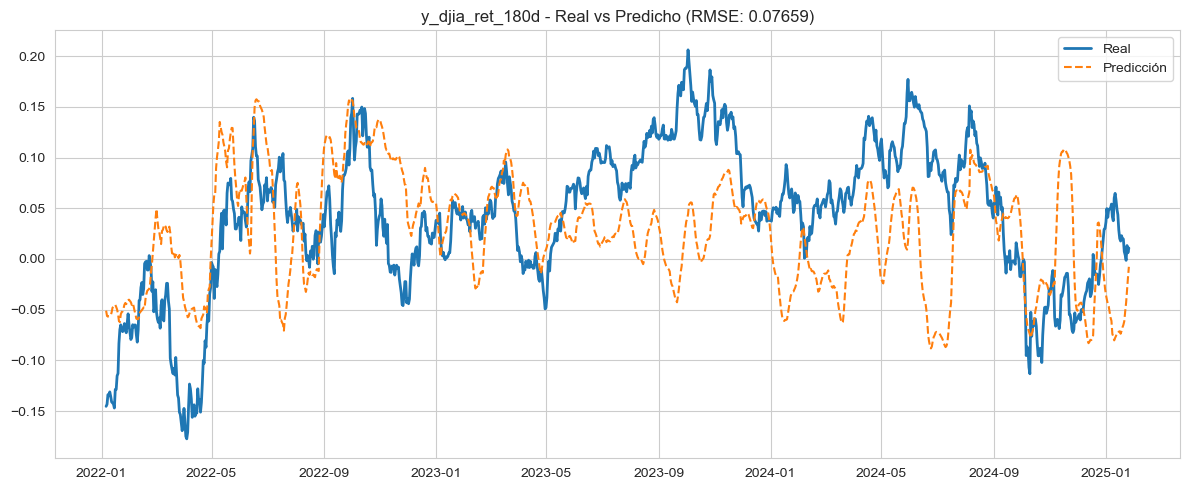

In [42]:
# ================================================================
# 6. Visualización de resultados
# ================================================================
for target, d in results.items():
    if d is None:
        continue

    y_test = d['y_test']                                # pd.Series con índice datetime
    y_pred = pd.Series(d['y_pred'], index=y_test.index) # alineamos al índice
    rmse   = d['rmse']

    plt.figure(figsize=(12, 5))
    plt.plot(y_test.index, y_test.values, label='Real', linewidth=2)
    plt.plot(y_test.index, y_pred.values, label='Predicción', linestyle='--')
    plt.title(f'{target} - Real vs Predicho (RMSE: {rmse:.5f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 7.2.3 Guardar Modelo en Azure Data Lake

In [43]:
# ================================================================
# Guardar solo los modelos entrenados (.pkl) en Azure Data Lake
# ================================================================
import joblib

MODEL_FAMILY = "lstm_pytorch_reg_v1"   # Personaliza según versión/modelo

for target, d in results.items():
    window = target.split("_")[-1]  # Extrae '5d', '20d', etc.
    model = d["model"]

    mdl_dir  = f"{CONTAINER}/models/{TICKER}/window={window}/model={MODEL_FAMILY}"
    mdl_path = f"{mdl_dir}/{TICKER}_{window}_{MODEL_FAMILY}.pkl"

    if not fs.exists(mdl_dir):
        fs.makedirs(mdl_dir, exist_ok=True)

    with fs.open(mdl_path, "wb") as f:
        joblib.dump(d, f)

    print(f"✔ Modelo guardado: {mdl_path}")

✔ Modelo guardado: market/models/DJIA/window=180d/model=lstm_pytorch_reg_v1/DJIA_180d_lstm_pytorch_reg_v1.pkl


## 7.3 Hibrido HistGradientBoostingRegressor + LSTM (pytorch) para Regresión

### 7.3.2 Entrenamiento

In [4]:
# ================================================================
# 7.4 Modelo Híbrido: HGBR (scikit-learn) + LSTM (PyTorch)
#     - Usa las mismas columnas que escogiste para cada modelo
#     - Respeta SEQ_LEN_BY_H de tu LSTM
#     - Mantiene estructura/hiperparámetros principales
# ================================================================
import pandas as pd
import numpy as np
import re
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# -----------------------------
# Reproducibilidad
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# -----------------------------
# Parámetros globales/modificables
# -----------------------------
split_date = '2022-01-01'
CALIB_FRAC = 0.25   # fracción inicial del test para calibrar el peso del blend
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Targets
targets = [f"y_{TICKER.lower()}_ret_5d"]
drop_cols_template = set(targets)

# Pérdida por horizonte (igual que 7.1)
LOSS_BY_TARGET = {
    f"y_{TICKER.lower()}_ret_5d":  "absolute_error",
    f"y_{TICKER.lower()}_ret_20d": "absolute_error",
    f"y_{TICKER.lower()}_ret_180d":"squared_error",
}

# ================================================================
# Selección de columnas por modelo y horizonte
#   -> REPLICA tus listas de 7.1 (HGBR) y 7.3 (LSTM)
# ================================================================
FEATS_BY_H_HGBR = {
    5:  [
        "BAA10Y","T5YIE","BAMLH0A0HYM2","ICSA","DCOILWTICO","VIXCLS",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    20: [
        "T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    180:[
        "T10Y3M","BAMLH0A0HYM2","ICSA","DTWEXBGS","BAA10Y","DGS10","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20",
        "bollinger_width","vol_std_ratio",
    ],
}

FEATS_BY_H_LSTM = {
    5:  [
        "BAA10Y","T5YIE","BAMLH0A0HYM2","ICSA","DCOILWTICO","VIXCLS",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    20: [
        "BAMLH0A0HYM2","M2SL","T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    180:[
        "T10Y3M","BAMLH0A0HYM2","ICSA","DTWEXBGS","BAA10Y","DGS10","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20",
        "bollinger_width","vol_std_ratio",
    ],
}

# Longitudes de secuencia por horizonte (igual que 7.3)
SEQ_LEN_BY_H = {
    5:   5,
    20:  10,
    180: 10,
}
DEFAULT_SEQ_LEN = 30

# -----------------------------
# Métricas auxiliares (robustas a NaNs)
# -----------------------------
def _safe_pair(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    return y_true[mask], y_pred[mask]

def directional_accuracy(y_true, y_pred):
    y_true, y_pred = _safe_pair(y_true, y_pred)
    if y_true.size == 0:
        return np.nan
    return float((np.sign(y_true) == np.sign(y_pred)).mean())

def sign_confusion_counts(y_true, y_pred):
    y_true, y_pred = _safe_pair(y_true, y_pred)
    if y_true.size == 0:
        return 0,0,0,0,0,np.nan,np.nan
    tp = int(((y_true > 0)  & (y_pred > 0)).sum())
    tn = int(((y_true <= 0) & (y_pred <= 0)).sum())
    fp = int(((y_true <= 0) & (y_pred > 0)).sum())
    fn = int(((y_true > 0)  & (y_pred <= 0)).sum())
    pos_total = tp + fn
    pos_hit_rate = float(tp / pos_total) if pos_total > 0 else np.nan
    neg_hit_rate = float(tn / (tn + fp)) if (tn + fp) > 0 else np.nan
    return tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate

def all_metrics(y_true, y_pred):
    y_true, y_pred = _safe_pair(y_true, y_pred)
    if y_true.size == 0:
        return dict(mse=np.nan, rmse=np.nan, mae=np.nan, r2=np.nan, da=np.nan,
                    tp=0, tn=0, fp=0, fn=0, pos_total=0,
                    pos_hit_rate=np.nan, neg_hit_rate=np.nan)
    mse  = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred)) if y_true.size > 1 else np.nan
    da   = directional_accuracy(y_true, y_pred)
    tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate = sign_confusion_counts(y_true, y_pred)
    return dict(mse=mse, rmse=rmse, mae=mae, r2=r2, da=da,
                tp=tp, tn=tn, fp=fp, fn=fn, pos_total=pos_total,
                pos_hit_rate=pos_hit_rate, neg_hit_rate=neg_hit_rate)

In [5]:
# ================================================================
# LSTM: dataset y modelo (igual a 7.3)
# ================================================================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.seq_len = seq_len
        self.X, self.y = [], []
        for i in range(seq_len, len(X)):
            self.X.append(X[i-seq_len:i])
            self.y.append(y[i])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out.squeeze()

# ================================================================
# Ingeniería de features + selección por ventana
#   (compartida pero con listas por modelo)
# ================================================================
def get_horizon_from_target(target: str) -> int:
    m = re.search(r"_ret_(\d+)d$", target)
    return int(m.group(1)) if m else None

def build_features(df: pd.DataFrame) -> pd.DataFrame:
    """Crea señales baratas (anchura Bollinger, ratio vol/std) si existen."""
    X = df.copy()
    up   = f'{TICKER.lower()}_bollinger_upper'
    lo   = f'{TICKER.lower()}_bollinger_lower'
    vol20 = f'{TICKER.lower()}_vol20'
    std20 = f'{TICKER.lower()}_std20'
    if all(col in X.columns for col in [up, lo]):
        X['bollinger_width'] = X[up] - X[lo]
    if all(col in X.columns for col in [vol20, std20]):
        X['vol_std_ratio'] = X[vol20] / (X[std20] + 1e-6)
    return X

def add_lags(X: pd.DataFrame) -> pd.DataFrame:
    """Crea lags de retornos del ticker si existen."""
    X = X.copy()
    lag_cols = [c for c in X.columns if c.startswith(f"{TICKER.lower()}_ret_")]
    for k in [1, 5, 20, 60, 120]:
        for c in lag_cols:
            ln = f"{c}_lag{k}"
            if ln not in X.columns:
                X[ln] = X[c].shift(k)
    return X

def select_features_by_model(X: pd.DataFrame, target: str, which: str) -> pd.DataFrame:
    """Filtra columnas permitidas según horizonte y modelo ('hgbr' o 'lstm')."""
    horizon = get_horizon_from_target(target)
    feats_map = FEATS_BY_H_HGBR if which == "hgbr" else FEATS_BY_H_LSTM
    base_allowed = [c for c in feats_map.get(horizon, []) if c in X.columns]

    # Lags dinámicos según horizonte (igual lógica a tus bloques)
    if horizon == 5:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(1|5|20)$"
    elif horizon == 20:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(5|20)$"
    else:  # 180d
        pat = rf"^{TICKER.lower()}_ret_.*_lag(60|120)$"
    dyn_lags = [c for c in X.columns if re.match(pat, c)]

    allowed = list(dict.fromkeys(base_allowed + dyn_lags))
    X_num = X.select_dtypes(include=[np.number]).copy()
    if len(allowed) > 0:
        allowed = [c for c in allowed if c in X_num.columns]
        if len(allowed) > 0:
            X_num = X_num[allowed].copy()
    return X_num

def prepare_for_model(df, target, which):
    """
    Prepara (X, y) para 'hgbr' o 'lstm' con:
      - ingeniería de features
      - lags
      - selección por ventana según modelo
    """
    # separar y y retirar otros targets
    drop_cols = list(drop_cols_template - {target})
    tmp = df.drop(columns=drop_cols + [target]).copy()
    y = df[target].copy()

    # features baratas + lags
    tmp = build_features(tmp)
    tmp = add_lags(tmp)

    # filtrar filas válidas de y
    valid_idx = ~y.isna()
    tmp = tmp.loc[valid_idx]
    y = y.loc[valid_idx]

    # selección por modelo y horizonte
    X = select_features_by_model(tmp, target, which=which)

    # orden temporal
    X = X.sort_index()
    y = y.sort_index()
    return X, y

In [6]:
# ================================================================
# HGBR (igual a 7.1, con imputaciones)
# ================================================================
def fit_predict_hgbr(df, target):
    X, y = prepare_for_model(df, target, which="hgbr")

    # split temporal
    X_train = X[X.index < split_date].copy()
    X_test  = X[X.index >= split_date].copy()
    y_train = y[y.index < split_date].copy()
    y_test  = y[y.index >= split_date].copy()

    # imputación como en 7.1
    X_train.ffill(inplace=True); X_train.bfill(inplace=True)
    X_test.ffill(inplace=True);  X_test.bfill(inplace=True)

    base_loss = LOSS_BY_TARGET.get(target, "squared_error")
    base_model = HistGradientBoostingRegressor(
        loss=base_loss,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=50,
        random_state=42
    )
    param_grid = {
        'max_iter': [600, 900, 1200, 1500],
        'learning_rate': [0.02, 0.05, 0.08, 0.1],
        'max_depth': [3, 4, 5, 6],
        'l2_regularization': [0.0, 0.1, 0.5, 1.0],
        'min_samples_leaf': [10, 20, 40, 80],
    }
    tscv = TimeSeriesSplit(n_splits=5)
    search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    search.fit(X_train.values, y_train.values)
    best_model = search.best_estimator_
    y_pred_test = best_model.predict(X_test.values)

    out = {
        "model": best_model,
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "y_pred": pd.Series(y_pred_test, index=X_test.index, name="y_pred_hgbr"),
        "features_used": X.columns.tolist()
    }
    return out

# ================================================================
# LSTM (igual a 7.3; usa SEQ_LEN_BY_H) + escalado
#   (dropna antes del split para evitar NaNs en secuencias)
# ================================================================
def fit_predict_lstm(df, target, device=DEVICE):
    horizon = get_horizon_from_target(target)
    X, y = prepare_for_model(df, target, which="lstm")

    # dropna conjunto (como tu 7.3 hacía)
    Xy = X.copy()
    Xy["__target__"] = y
    Xy = Xy.replace([np.inf, -np.inf], np.nan).dropna()
    if Xy.empty:
        return {"model": None, "scaler": None, "seq_len": None,
                "X_train": None, "X_test": None, "y_train": None, "y_test": None,
                "y_pred": pd.Series(dtype=float), "features_used": X.columns.tolist()}

    y = Xy.pop("__target__")
    X = Xy

    # split temporal
    X_train = X[X.index < split_date].copy()
    X_test  = X[X.index >= split_date].copy()
    y_train = y[y.index < split_date].copy()
    y_test  = y[y.index >= split_date].copy()

    # escalado sólo con train
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train.values)
    X_test_sc  = scaler.transform(X_test.values)

    seq_len = SEQ_LEN_BY_H.get(horizon, DEFAULT_SEQ_LEN)
    train_ds = TimeSeriesDataset(X_train_sc, y_train.values, seq_len)
    test_ds  = TimeSeriesDataset(X_test_sc,  np.zeros(len(X_test)), seq_len)  # y no usada en pred

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

    model = LSTMRegressor(input_dim=X.shape[1], hidden_dim=64, num_layers=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(30):
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # pred en test (arranca desde seq_len)
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            p = model(xb).cpu().numpy()
            preds.extend(p)
    preds = np.array(preds, dtype=float)

    test_idx_aligned = X_test.index[seq_len:]
    y_pred_series = pd.Series(preds, index=test_idx_aligned, name="y_pred_lstm")

    out = {
        "model": model, "scaler": scaler, "seq_len": seq_len,
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "y_pred": y_pred_series,
        "features_used": X.columns.tolist()
    }
    return out

# ================================================================
# NUEVO: calibración de mezcla con bias y objetivo seleccionable
# ================================================================
from sklearn.metrics import mean_absolute_error

def _balanced_sign_score(y_true, y_pred):
    """Devuelve el promedio de hit rates en positivos y negativos.
       (1.0 es mejor; si no hay negativos/positivos válidos, usa sólo el existente)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]; y_pred = y_pred[mask]
    if y_true.size == 0:
        return np.nan
    pos_true = y_true > 0
    neg_true = ~pos_true
    pos_pred = y_pred > 0
    neg_pred = ~pos_pred

    # hit rates
    pos_total = pos_true.sum()
    neg_total = neg_true.sum()
    pos_hit = (pos_true & pos_pred).sum() / pos_total if pos_total > 0 else np.nan
    neg_hit = (neg_true & neg_pred).sum() / neg_total if neg_total > 0 else np.nan

    if np.isnan(pos_hit) and np.isnan(neg_hit):
        return np.nan
    if np.isnan(pos_hit):
        return float(neg_hit)
    if np.isnan(neg_hit):
        return float(pos_hit)
    return float(0.5 * (pos_hit + neg_hit))

def calibrate_blend(
    y_true, y_hgbr, y_lstm,
    calib_frac=0.25,
    objective="mae",      # "mae" | "da" | "balanced_da"
    add_bias=True,        # añade bias c = mediana residual en calibración
    ws=None               # grid de pesos; por defecto 0..1 cada 0.05
):
    if ws is None:
        ws = np.linspace(0, 1, 21)

    # Alinear y limpiar
    idx = y_true.index.intersection(y_hgbr.index).intersection(y_lstm.index)
    if len(idx) == 0:
        return 0.5, 0.0, pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)

    df = pd.DataFrame({
        "y": y_true.loc[idx].astype(float),
        "a": y_hgbr.loc[idx].astype(float),
        "b": y_lstm.loc[idx].astype(float),
    }).replace([np.inf, -np.inf], np.nan).dropna()

    if df.empty:
        return 0.5, 0.0, pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)

    # Split calibración / evaluación
    n_calib = max(1, int(len(df) * calib_frac))
    df_cal = df.iloc[:n_calib].copy()
    df_eval = df.iloc[n_calib:].copy()
    if df_eval.empty:
        df_eval = df.iloc[-1:].copy()  # fallback

    best_w, best_c = 0.5, 0.0
    best_score = np.inf if objective == "mae" else -np.inf

    for w in ws:
        blend_cal = w*df_cal["a"].values + (1-w)*df_cal["b"].values
        c = np.median(df_cal["y"].values - blend_cal) if add_bias else 0.0
        pred_cal = blend_cal + c

        if objective == "mae":
            score = mean_absolute_error(df_cal["y"].values, pred_cal)
            is_better = score < best_score
        elif objective == "da":
            da = (np.sign(df_cal["y"].values) == np.sign(pred_cal)).mean()
            score = da
            is_better = score > best_score
        elif objective == "balanced_da":
            bsc = _balanced_sign_score(df_cal["y"].values, pred_cal)
            # si no es computable, castiga
            score = bsc if np.isfinite(bsc) else -np.inf
            is_better = score > best_score
        else:
            raise ValueError("objective debe ser 'mae', 'da' o 'balanced_da'.")

        if is_better:
            best_w, best_c, best_score = w, c, score

    # Predicción híbrida en evaluación
    y_eval = df_eval["y"]
    a_eval = df_eval["a"]
    b_eval = df_eval["b"]
    y_hybrid_eval = best_w*a_eval + (1-best_w)*b_eval + best_c

    return float(best_w), float(best_c), y_eval, a_eval, b_eval, y_hybrid_eval

In [7]:
# ================================================================
# Loop principal por target
# ================================================================
hybrid_results = {}

for target in targets:
    print(f"\n🔄 Entrenando modelo HÍBRIDO para: {target}\n{'-'*70}")

    # --- HGBR (con sus columnas) ---
    hgbr = fit_predict_hgbr(df, target)
    y_test_hgbr = hgbr["y_test"]
    y_pred_hgbr = hgbr["y_pred"]

    # --- LSTM (con sus columnas + SEQ_LEN_BY_H) ---
    lstm = fit_predict_lstm(df, target, device=DEVICE)
    y_test_lstm = lstm["y_test"]
    y_pred_lstm = lstm["y_pred"]

    # --- Calibración de blend en parte inicial del test alineado ---
    # Nota: y_true tomamos del mismo índice común del test
    #       Usamos y_test de HGBR (cubre todo test) y se alinea con LSTM por índice
    w, c, y_eval, a_eval, b_eval, h_eval = calibrate_blend(
        y_test_hgbr, y_pred_hgbr, y_pred_lstm,
        calib_frac=CALIB_FRAC,
        objective="balanced_da",   # prueba: "balanced_da" para mejorar NegHit
        add_bias=True
    )
    print(f"⚖️ Peso híbrido w (HGBR): {w:.2f} | (LSTM): {1-w:.2f} | Bias c: {c:+.6f}")
    if len(y_eval) == 0:
        print("⚠️ Sin datos suficientes tras la alineación/limpieza para evaluar el híbrido.")
        continue

    # --- Métricas ---
    hgbr_metrics   = all_metrics(y_eval.values, a_eval.values)
    lstm_metrics   = all_metrics(y_eval.values, b_eval.values)
    hybrid_metrics = all_metrics(y_eval.values, h_eval.values)

    print(
        f"⚖️ Peso híbrido w (HGBR): {w:.2f} | (LSTM): {1-w:.2f}\n"
        f"✅ {target} | HGBR   -> RMSE: {hgbr_metrics['rmse']:.6f} | MAE: {hgbr_metrics['mae']:.6f} | R²: {hgbr_metrics['r2']:.3f} | DA: {hgbr_metrics['da']:.3f}\n"
        f"✅ {target} | LSTM   -> RMSE: {lstm_metrics['rmse']:.6f} | MAE: {lstm_metrics['mae']:.6f} | R²: {lstm_metrics['r2']:.3f} | DA: {lstm_metrics['da']:.3f}\n"
        f"✅ {target} | HÍBRIDO-> RMSE: {hybrid_metrics['rmse']:.6f} | MAE: {hybrid_metrics['mae']:.6f} | R²: {hybrid_metrics['r2']:.3f} | DA: {hybrid_metrics['da']:.3f}\n"
        f"   PosHit: {hybrid_metrics['pos_hit_rate']:.3f} ({hybrid_metrics['tp']}/{hybrid_metrics['pos_total']}) | "
        f"NegHit: {hybrid_metrics['neg_hit_rate']:.3f} ({hybrid_metrics['tn']}/{hybrid_metrics['tn']+hgbr_metrics['fp']})"
    )

    # --- Guardar en results ---
    hybrid_results[target] = {
        # Modelos y sets
        "blend_bias": float(c),
        "hgbr_model": hgbr["model"],
        "lstm_model": lstm["model"],
        "lstm_scaler": lstm["scaler"],
        "lstm_seq_len": lstm["seq_len"],
        "hgbr_features_used": hgbr["features_used"],
        "lstm_features_used": lstm["features_used"],
        "y_test_full": y_test_hgbr,                 # test completo (HGBR)
        "y_pred_hgbr_full": y_pred_hgbr,           # pred HGBR en test completo
        "y_pred_lstm_full": y_pred_lstm,           # pred LSTM (desplazada por seq_len)
        # Evaluación (parte hold-out dentro de test alineado)
        "y_test": y_eval,
        "y_pred_hgbr_eval": a_eval,
        "y_pred_lstm_eval": b_eval,
        "y_pred": h_eval,
        # Peso y métricas
        "blend_weight_hgbr": float(w),
        "blend_weight_lstm": float(1-w),
        "metrics_hgbr": hgbr_metrics,
        "metrics_lstm": lstm_metrics,
        # Métricas híbridas al nivel superior
        "metrics_hybrid": hybrid_metrics,
        "rmse": hybrid_metrics["rmse"],
        "mae": hybrid_metrics["mae"],
        "r2": hybrid_metrics["r2"],
        "da": hybrid_metrics["da"],
        "tp": hybrid_metrics["tp"],
        "tn": hybrid_metrics["tn"],
        "fp": hybrid_metrics["fp"],
        "fn": hybrid_metrics["fn"],
        "pos_total": hybrid_metrics["pos_total"],
        "pos_hit_rate": hybrid_metrics["pos_hit_rate"],
        "neg_hit_rate": hybrid_metrics["neg_hit_rate"],
        # Info
        "horizon": get_horizon_from_target(target),
        "split_date": split_date,
        "calib_frac": CALIB_FRAC,
        "tipoModel": "Regresión",
        'ticker': TICKER
    }


🔄 Entrenando modelo HÍBRIDO para: y_djia_ret_5d
----------------------------------------------------------------------
⚖️ Peso híbrido w (HGBR): 0.55 | (LSTM): 0.45 | Bias c: -0.008238
⚖️ Peso híbrido w (HGBR): 0.55 | (LSTM): 0.45
✅ y_djia_ret_5d | HGBR   -> RMSE: 0.017066 | MAE: 0.012400 | R²: -0.103 | DA: 0.547
✅ y_djia_ret_5d | LSTM   -> RMSE: 0.016546 | MAE: 0.012191 | R²: -0.037 | DA: 0.491
✅ y_djia_ret_5d | HÍBRIDO-> RMSE: 0.018164 | MAE: 0.014266 | R²: -0.250 | DA: 0.455
   PosHit: 0.102 (57/558) | NegHit: 0.934 (384/669)


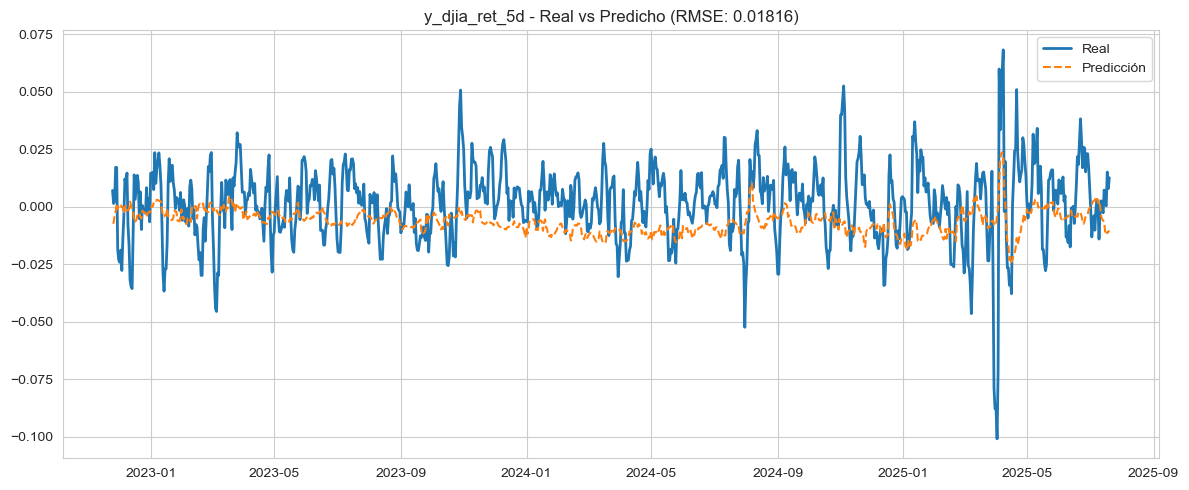

In [8]:
# ================================================================
# 6. Visualización
# ================================================================
import matplotlib.pyplot as plt
import pandas as pd

for target, data in hybrid_results.items():
    if data is None:
        continue

    y_test = data['y_test']                                  # pd.Series con índice datetime
    y_pred = pd.Series(data['y_pred'], index=y_test.index)   # alineamos al índice
    rmse   = data['rmse']

    plt.figure(figsize=(12, 5))
    plt.plot(y_test.index, y_test.values, label='Real', linewidth=2)
    plt.plot(y_pred.index, y_pred.values, label='Predicción', linestyle='--')
    plt.title(f'{target} - Real vs Predicho (RMSE: {rmse:.5f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 7.3.3 Guardar Modelo en Azure Data Lake

In [61]:
# ================================================================
# Definir clase para modelo híbrido (HGBR + LSTM + blend)
# ================================================================
import joblib
import torch
import numpy as np

class HybridModel:
    def __init__(self, hgbr_model, lstm_model, blend_weight_hgbr, blend_bias):
        self.hgbr_model = hgbr_model
        self.lstm_model = lstm_model
        self.w = blend_weight_hgbr
        self.c = blend_bias

    def predict(self, X_hgbr, X_lstm):
        y_hgbr = self.hgbr_model.predict(X_hgbr)
        self.lstm_model.eval()
        with torch.no_grad():
            y_lstm = self.lstm_model(X_lstm).cpu().numpy().ravel()
        return self.w * y_hgbr + (1 - self.w) * y_lstm + self.c

# ================================================================
# Guardar modelos híbridos entrenados (.pkl) en Azure Data Lake
# ================================================================
MODEL_FAMILY = "hgb_lstm_hybrid_reg_v1"   # Personaliza según versión/modelo

for target, d in hybrid_results.items():
    window = target.split("_")[-1]  # Extrae '5d', '20d', etc.

    # Construir modelo híbrido como objeto
    hybrid_model = HybridModel(
        hgbr_model=d["hgbr_model"],
        lstm_model=d["lstm_model"],
        blend_weight_hgbr=d["blend_weight_hgbr"],
        blend_bias=d["blend_bias"]
    )
    d["model"] = hybrid_model  # Asignar al diccionario

    # Definir ruta en Data Lake
    mdl_dir  = f"{CONTAINER}/models/{TICKER}/window={window}/model={MODEL_FAMILY}"
    mdl_path = f"{mdl_dir}/{TICKER}_{window}_{MODEL_FAMILY}.pkl"

    if not fs.exists(mdl_dir):
        fs.makedirs(mdl_dir, exist_ok=True)

    # Guardar con joblib
    with fs.open(mdl_path, "wb") as f:
        joblib.dump(d, f)

    print(f"✔ Modelo híbrido guardado: {mdl_path}")

✔ Modelo híbrido guardado: market/models/DJIA/window=180d/model=hgb_lstm_hybrid_reg_v1/DJIA_180d_hgb_lstm_hybrid_reg_v1.pkl


# Entrenamiento de modelos de Clasificación Machine Learning

## 8.1 HistGradientBoostingClassifier con Optimización de Hiperparámetros y Selección de Variables por Ventana Temporal

### 8.1.2 Entrenamiento

In [62]:
# ================================================================
# 8.1.1 Importar Librerias necesarias
# ================================================================
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score,
    precision_score, recall_score, average_precision_score,
    matthews_corrcoef, confusion_matrix, brier_score_loss, log_loss
)

import matplotlib.pyplot as plt

In [63]:
# ================================================================
# 8.1.2 Almacenar resultados para cada ventana
# ================================================================
results = {}

targets = [f"y_{TICKER.lower()}_ret_5d",
           f"y_{TICKER.lower()}_ret_20d",
           f"y_{TICKER.lower()}_ret_180d"]
drop_cols_template = set(targets)

# Mapeo de pérdida por horizonte (clasificación)
LOSS_BY_TARGET = {
    f"y_{TICKER.lower()}_ret_5d":  "log_loss",
    f"y_{TICKER.lower()}_ret_20d": "log_loss",
    f"y_{TICKER.lower()}_ret_180d":"log_loss",
}

# -------------------------
# Listas de features por ventana (macro/tecnicos)
# (se intersectan con X; si falta alguna no rompe)
# -------------------------
FEATS_BY_H = {
    5:  [
        # macro/alta frecuencia
        "ICSA","T10Y3M","DCOILWTICO","VIXCLS",
        # técnicos del índice
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        # (si existen) agregadas siempre:
        "bollinger_width","vol_std_ratio",
    ],
    20: [
        "T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    180:[
        "BAMLH0A0HYM2","BAA10Y","DGS10","T10Y3M","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20",
        "bollinger_width","vol_std_ratio",
    ],
}


In [64]:
## ================================================================
# 8.1.3 Entrenamiento con Histogram-based Gradient Boosting Classifier
#    (ajustes finos por horizonte, cambios mínimos)
# ================================================================
import numpy as np
import pandas as pd
import re
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, roc_curve, matthews_corrcoef,
    average_precision_score, balanced_accuracy_score, precision_score,
    recall_score, confusion_matrix, brier_score_loss, log_loss
)
from sklearn.isotonic import IsotonicRegression

# ---------- SOLO CONSTANTES (AJUSTES POR HORIZONTE) ----------
# ε (zona neutra)
EPS_BY_H = {5: 0.0015, 20: 0.0020, 180: 0.0100}

# Rails (±) alrededor de la tasa base
RAILS_BY_H = {5: 0.12, 20: 0.10, 180: 0.02}

# Mínimos por horizonte
SPEC_MIN_BY_H   = {5: 0.45, 20: 0.45, 180: 0.35}
RECALL_MIN_BY_H = {5: 0.50, 20: 0.55, 180: 0.80}

# Flip prudente (AUC bajo en validación)
AUC_FLIP_CUTOFF_BY_H = {5: 0.48, 20: 0.48, 180: 0.45}

# Métrica de búsqueda en CV
SCORING_BY_H = {5: 'roc_auc', 20: 'roc_auc', 180: 'balanced_accuracy'}

CALIBRATE = True  # isotónica para estabilizar probabilidades

results = {}

for target in targets:
    print(f"\n🔄 Entrenando modelo para: {target}\n{'-'*50}")
    
    # --- 1) Selección de columnas y target (continuo) ---
    drop_cols = list(drop_cols_template - {target})
    X = df.drop(columns=drop_cols + [target]).copy()
    y_cont_full = df[target].copy()

    # --- 2) Feature engineering básico ---
    up   = f'{TICKER.lower()}_bollinger_upper'
    lo   = f'{TICKER.lower()}_bollinger_lower'
    vol20 = f'{TICKER.lower()}_vol20'
    std20 = f'{TICKER.lower()}_std20'
    if all(c in X.columns for c in [up, lo]):
        X['bollinger_width'] = X[up] - X[lo]
    if all(c in X.columns for c in [vol20, std20]):
        X['vol_std_ratio'] = X[vol20] / (X[std20] + 1e-6)

    # Lags del índice (si existen)
    lag_cols = [c for c in X.columns if c.startswith(f"{TICKER.lower()}_ret_")]
    for k in [1, 5, 20, 60, 120]:
        for c in lag_cols:
            lag_name = f"{c}_lag{k}"
            if lag_name not in X.columns:
                X[lag_name] = X[c].shift(k)

    # --- 2.1 Selección personalizada por ventana ---
    horizon = int(target.rsplit('_', 1)[-1].replace('d',''))  # 5, 20, 180
    base_allowed = [c for c in FEATS_BY_H.get(horizon, []) if c in X.columns]
    if horizon == 5:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(1|5|20)$"
    elif horizon == 20:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(5|20)$"
    else:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(60|120)$"
    dyn_lags = [c for c in X.columns if re.match(pat, c)]
    allowed = list(dict.fromkeys(base_allowed + dyn_lags))
    X = X.select_dtypes(include=[np.number])
    if len(allowed) > 0:
        allowed = [c for c in allowed if c in X.columns]
        if len(allowed) > 0:
            X = X[allowed].copy()

    # --- 2.2 Zona neutra (ε) + binarización ---
    eps = EPS_BY_H.get(horizon, 0.0)
    mask_nonan = ~y_cont_full.isna()
    n_total = int(mask_nonan.sum())

    y_cont = y_cont_full.copy()
    mask_neutral = y_cont.abs() >= eps
    X = X.loc[mask_neutral]
    y_cont = y_cont.loc[mask_neutral]
    y = (y_cont > 0).astype(int)

    # --- 3) Filtrar filas con target disponible ---
    valid_idx = ~y_cont.isna()
    X, y = X.loc[valid_idx], y.loc[valid_idx]

    coverage = float(len(y) / n_total) if n_total > 0 else np.nan
    base_rate_all = float((y == 1).mean()) if len(y) else np.nan
    print(f"• Cobertura tras ε={eps:.4f}: {coverage:.3f} | BaseRate (post-ε): {base_rate_all:.3f}")

    # --- 4) Split temporal ---
    split_date = '2022-01-01'
    X_train = X[X.index < split_date].copy()
    X_test  = X[X.index >= split_date].copy()
    y_train = y[y.index < split_date].copy()
    y_test  = y[y.index >= split_date].copy()

    # --- 5) Imputación simple ---
    X_train.ffill(inplace=True); X_train.bfill(inplace=True)
    X_test.ffill(inplace=True);  X_test.bfill(inplace=True)
    X_train_np = X_train.values
    X_test_np  = X_test.values

    # --- 6) Estimador base + búsqueda ---
    base_model = HistGradientBoostingClassifier(
        loss="log_loss",
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=50,
        random_state=42
    )
    param_grid = {
        'max_iter': [600, 900, 1200, 1500],
        'learning_rate': [0.02, 0.05, 0.08, 0.1],
        'max_depth': [3, 4, 5, 6],
        'l2_regularization': [0.0, 0.1, 0.5, 1.0],
        'min_samples_leaf': [10, 20, 40, 80],
    }
    tscv = TimeSeriesSplit(n_splits=5, gap=horizon)
    search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,
        cv=tscv,
        scoring=SCORING_BY_H.get(horizon, 'roc_auc'),
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    pos = y_train.sum()
    neg = len(y_train) - pos
    w_pos = len(y_train) / (2.0 * pos) if pos > 0 else 1.0
    w_neg = len(y_train) / (2.0 * neg) if neg > 0 else 1.0
    sample_weight_train = np.where(y_train.values == 1, w_pos, w_neg)
    search.fit(X_train_np, y_train, sample_weight=sample_weight_train)
    best_model = search.best_estimator_

    # --- 6.1 Umbral con rails + Spec/Recall mínimos + flip prudente + calibración ---
    cut = int(len(X_train_np) * 0.8)
    X_tr2, X_val = X_train_np[:cut], X_train_np[cut:]
    y_tr2, y_val = y_train.values[:cut], y_train.values[cut:]

    invert_probs = False
    calibrator = None

    if np.unique(y_val).size < 2:
        best_threshold = 0.5
        best_model.fit(X_train_np, y_train, sample_weight=sample_weight_train)
    else:
        sample_weight_tr2 = sample_weight_train[:cut]
        best_model.fit(X_tr2, y_tr2, sample_weight=sample_weight_tr2)

        try:
            proba_val = best_model.predict_proba(X_val)[:, 1]
        except AttributeError:
            if hasattr(best_model, "decision_function"):
                from sklearn.preprocessing import MinMaxScaler
                scores = best_model.decision_function(X_val).reshape(-1, 1)
                proba_val = MinMaxScaler().fit_transform(scores).ravel()
            else:
                proba_val = np.full_like(y_val, fill_value=0.5, dtype=float)

        auc_val = roc_auc_score(y_val, proba_val) if len(np.unique(y_val)) == 2 else 0.5
        if auc_val < AUC_FLIP_CUTOFF_BY_H.get(horizon, 0.48):
            proba_val = 1.0 - proba_val
            invert_probs = True

        if CALIBRATE:
            calibrator = IsotonicRegression(out_of_bounds='clip')
            calibrator.fit(proba_val, y_val)
            proba_val = calibrator.transform(proba_val)

        base_rate_tr = float((y_tr2 == 1).mean())
        rails = RAILS_BY_H.get(horizon, 0.08)
        lo, hi = max(0.05, base_rate_tr - rails), min(0.95, base_rate_tr + rails)
        spec_min = SPEC_MIN_BY_H.get(horizon, 0.30)
        rec_min  = RECALL_MIN_BY_H.get(horizon, 0.50)

        grid = np.linspace(0.05, 0.95, 91)

        def stats_at(t):
            y_hat = (proba_val >= t).astype(int)
            if len(np.unique(y_hat)) < 2:
                return -1.0, 0.0, 0.0, 0.0, 1.0
            ba = balanced_accuracy_score(y_val, y_hat)
            ppr = (y_hat == 1).mean()
            tn, fp, fn, tp = confusion_matrix(y_val, y_hat, labels=[0, 1]).ravel()
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            gap  = abs(rec - spec)
            return ba, ppr, spec, rec, gap

        cands = [(t,) + stats_at(t) for t in grid]
        band  = [(t, ba, ppr, spec, rec, gap) for (t, ba, ppr, spec, rec, gap) in cands
                 if (lo <= ppr <= hi and spec >= spec_min and rec >= rec_min)]

        if len(band) > 0:
            band.sort(key=lambda x: (x[1], -x[5]))  # max BA, min gap
            best_threshold = float(band[-1][0])
        else:
            # Fallback: max BA con desempate por menor asimetría
            t_best, best_ba, best_gap = 0.5, -1.0, 1.0
            for (t, ba, ppr, spec, rec, gap) in cands:
                if (ba > best_ba) or (np.isclose(ba, best_ba) and gap < best_gap):
                    t_best, best_ba, best_gap = t, ba, gap
            best_threshold = float(t_best)

        # Reentrenar en TODO el train
        best_model.fit(X_train_np, y_train, sample_weight=sample_weight_train)

    # --- 7) Evaluación en Test ---
    try:
        y_pred_proba = best_model.predict_proba(X_test_np)[:, 1]
    except AttributeError:
        if hasattr(best_model, "decision_function"):
            from sklearn.preprocessing import MinMaxScaler
            scores = best_model.decision_function(X_test_np).reshape(-1, 1)
            y_pred_proba = MinMaxScaler().fit_transform(scores).ravel()
        else:
            y_pred_proba = best_model.predict(X_test_np).astype(float)

    if invert_probs:
        y_pred_proba = 1.0 - y_pred_proba
    if CALIBRATE and (calibrator is not None):
        y_pred_proba = calibrator.transform(y_pred_proba)

    y_pred = (y_pred_proba >= best_threshold).astype(int)
    y_true = y_test.values

    auc_roc = float(roc_auc_score(y_true, y_pred_proba)) if y_test.nunique() == 2 else np.nan
    ap      = float(average_precision_score(y_true, y_pred_proba))
    acc     = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))
    prec    = float(precision_score(y_true, y_pred, zero_division=0))
    recall  = float(recall_score(y_true, y_pred, zero_division=0))
    f1      = float(f1_score(y_true, y_pred, zero_division=0))
    mcc     = float(matthews_corrcoef(y_true, y_pred)) if (len(np.unique(y_true)) == 2 and len(np.unique(y_pred)) == 2) else np.nan

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    pos_total = int((y_true == 1).sum())
    neg_total = int((y_true == 0).sum())
    pos_hit_rate = tp / pos_total if pos_total > 0 else np.nan
    neg_hit_rate = tn / neg_total if neg_total > 0 else np.nan

    brier   = float(brier_score_loss(y_true, y_pred_proba))
    ll      = float(log_loss(y_true, y_pred_proba, labels=[0, 1]))

    base_rate   = float(pos_total / (pos_total + neg_total))
    pred_pos_rt = float((y_pred == 1).mean())

    print(
        f"✅ {target} | AUC: {auc_roc:.6f} | PR-AUC: {ap:.6f} | ACC: {acc:.3f} | BalAcc: {bal_acc:.3f} | "
        f"F1: {f1:.3f} | Prec: {prec:.3f} | Recall/TPR: {recall:.3f} | Spec/TNR: {neg_hit_rate:.3f} | "
        f"MCC: {mcc:.3f} | Brier: {brier:.6f} | LogLoss: {ll:.6f} | thr={best_threshold:.3f} | "
        f"PosHit: {pos_hit_rate:.3f} ({tp}/{pos_total}) | NegHit: {neg_hit_rate:.3f} ({tn}/{tn+fp}) | "
        f"BaseRate: {base_rate:.3f} | PredPosRate: {pred_pos_rt:.3f} | invert={invert_probs}"
    )

    # --- 8) Guardar resultados ---
    results[target] = {
        'ticker': TICKER,
        "tipoModel": "Clasificación",
        'model': best_model,
        'features_used': X.columns.tolist(),
        'y_test': y_test,
        'y_pred': pd.Series(y_pred, index=y_test.index),
        'y_pred_proba': pd.Series(y_pred_proba, index=y_test.index),

        # Métricas de discriminación
        'auc': auc_roc, 'pr_auc': ap,

        # Métricas a umbral
        'accuracy': acc, 'balanced_accuracy': bal_acc,
        'precision': prec, 'recall': recall, 'specificity': neg_hit_rate,
        'f1': f1, 'mcc': mcc, 'threshold': best_threshold,

        # Calibración
        'brier': brier, 'log_loss': ll,

        # Conteos y tasas
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'pos_total': pos_total, 'neg_total': neg_total,
        'pos_hit_rate': pos_hit_rate, 'neg_hit_rate': neg_hit_rate,
        'base_rate': base_rate, 'pred_pos_rate': pred_pos_rt,

        # Info extra
        'coverage_post_eps': coverage, 'base_rate_post_eps': base_rate_all,
        'invert_probs': invert_probs, 'calibrated': CALIBRATE,
    }


🔄 Entrenando modelo para: y_djia_ret_5d
--------------------------------------------------
• Cobertura tras ε=0.0015: 0.917 | BaseRate (post-ε): 0.567
✅ y_djia_ret_5d | AUC: 0.479447 | PR-AUC: 0.540948 | ACC: 0.449 | BalAcc: 0.494 | F1: 0.071 | Prec: 0.481 | Recall/TPR: 0.038 | Spec/TNR: 0.950 | MCC: -0.029 | Brier: 0.250210 | LogLoss: 0.693677 | thr=0.590 | PosHit: 0.038 (25/654) | NegHit: 0.950 (510/537) | BaseRate: 0.549 | PredPosRate: 0.044 | invert=True

🔄 Entrenando modelo para: y_djia_ret_20d
--------------------------------------------------
• Cobertura tras ε=0.0020: 0.952 | BaseRate (post-ε): 0.617
✅ y_djia_ret_20d | AUC: 0.516068 | PR-AUC: 0.589702 | ACC: 0.516 | BalAcc: 0.508 | F1: 0.572 | Prec: 0.587 | Recall/TPR: 0.559 | Spec/TNR: 0.457 | MCC: 0.015 | Brier: 0.263547 | LogLoss: 0.728781 | thr=0.680 | PosHit: 0.559 (400/716) | NegHit: 0.457 (237/519) | BaseRate: 0.580 | PredPosRate: 0.552 | invert=False

🔄 Entrenando modelo para: y_djia_ret_180d
--------------------------

### 8.1.3 Guardar Modelo en Azure Data Lake

In [65]:
# ================================================================
# Guardar solo los modelos entrenados (.pkl) en Azure Data Lake
# ================================================================
import joblib

MODEL_FAMILY = "hgb_opt_featbywindow_clf_v1"   # Personaliza según versión/modelo

for target, d in results.items():
    window = target.split("_")[-1]  # Extrae '5d', '20d', etc.
    model = d["model"]

    mdl_dir  = f"{CONTAINER}/models/{TICKER}/window={window}/model={MODEL_FAMILY}"
    mdl_path = f"{mdl_dir}/{TICKER}_{window}_{MODEL_FAMILY}.pkl"

    if not fs.exists(mdl_dir):
        fs.makedirs(mdl_dir, exist_ok=True)

    with fs.open(mdl_path, "wb") as f:
        joblib.dump(d, f)

    print(f"✔ Modelo guardado: {mdl_path}")

✔ Modelo guardado: market/models/DJIA/window=5d/model=hgb_opt_featbywindow_clf_v1/DJIA_5d_hgb_opt_featbywindow_clf_v1.pkl
✔ Modelo guardado: market/models/DJIA/window=20d/model=hgb_opt_featbywindow_clf_v1/DJIA_20d_hgb_opt_featbywindow_clf_v1.pkl
✔ Modelo guardado: market/models/DJIA/window=180d/model=hgb_opt_featbywindow_clf_v1/DJIA_180d_hgb_opt_featbywindow_clf_v1.pkl


## 8.2 Modelo LSTM (pytorch) para clasificación

### 8.2.2 Entrenamiento

In [80]:
# ================================================================
# 1. Librerías
# ================================================================
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error, 
    roc_auc_score, roc_curve, f1_score, accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Si usas GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ================================================================
# 1.1 Selección de columnas por ventana (igual que HGBR/XGB)
#    (edita estas listas si quieres añadir/quitar señales)
# ================================================================
FEATS_BY_H = {
    5:  [
        # macro/alta frecuencia
        "BAA10Y","T5YIE","BAMLH0A0HYM2","ICSA","DCOILWTICO","VIXCLS",
        # técnicos del índice
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        # (si existen) agregadas siempre:
        "bollinger_width","vol_std_ratio",
    ],
    20: [
        "BAMLH0A0HYM2","M2SL","T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    180:[
        "T10Y3M","BAMLH0A0HYM2","ICSA","DTWEXBGS","BAA10Y","DGS10","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20",
        "bollinger_width","vol_std_ratio",
    ],
} 

# === Helpers de métricas para clasificación ===
def safe_confusion_counts(y_true_bin, y_pred_bin):
    """
    Devuelve tp, tn, fp, fn y tasas por clase. Robusto cuando falta alguna clase.
    """
    y_true_bin = np.asarray(y_true_bin).astype(int)
    y_pred_bin = np.asarray(y_pred_bin).astype(int)

    # confusion_matrix con etiquetas fijas [0,1] garantiza 2x2
    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    pos_total = tp + fn
    neg_total = tn + fp
    pos_hit_rate = float(tp / pos_total) if pos_total > 0 else np.nan
    neg_hit_rate = float(tn / neg_total) if neg_total > 0 else np.nan
    return tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate

def find_best_threshold(y_true_bin, y_prob, how="f1"):
    """
    Busca el umbral que maximiza F1 (por defecto) sobre el conjunto de evaluación.
    Si no hay positivos/negativos, retorna 0.5.
    """
    y_true_bin = np.asarray(y_true_bin).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    # Si no hay ambas clases, devolvemos threshold neutro 0.5
    if len(np.unique(y_true_bin)) < 2:
        return 0.5

    # Usamos puntos de roc_curve como candidatos + una grilla fina
    fpr, tpr, roc_ths = roc_curve(y_true_bin, y_prob)
    grid = np.linspace(0.01, 0.99, 99)
    cands = np.unique(np.clip(np.concatenate([roc_ths, grid]), 1e-6, 1 - 1e-6))

    best_thr = 0.5
    best_score = -np.inf
    for thr in cands:
        pred_bin = (y_prob >= thr).astype(int)
        if how == "f1":
            score = f1_score(y_true_bin, pred_bin, zero_division=0)
        else:
            score = accuracy_score(y_true_bin, pred_bin)
        if score > best_score:
            best_score = score
            best_thr = float(thr)
    return best_thr

In [81]:
# ================================================================
# 2. Dataset tipo secuencia (igual que antes)
# ================================================================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.seq_len = seq_len
        self.X, self.y = [], []
        for i in range(seq_len, len(X)):
            self.X.append(X[i-seq_len:i])
            self.y.append(y[i])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        # Para BCE usaremos float32 (0/1) como objetivos
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [82]:
# ================================================================
# 3. Modelo LSTM Classifier (cambia fc+loss; resto igual)
# ================================================================
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # logit para clase positiva

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        logits = self.fc(hn[-1])  # [B,1]
        return logits.squeeze(-1)  # regresamos logits 1D

In [83]:
# ================================================================
# 4. Entrenamiento para cada ventana (idéntica selección de columnas)
#    Ahora binarizamos y entrenamos con BCEWithLogitsLoss
# ================================================================
def train_lstm_classifier_for_target(
    df,
    target,
    seq_len=10,
    epochs=30,
    batch_size=32,
    hidden_dim=64,
    num_layers=1,
    lr=1e-3,
    device=None
):
    df = df.copy()
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_targets = [f"y_{TICKER.lower()}_ret_5d",
                   f"y_{TICKER.lower()}_ret_20d",
                   f"y_{TICKER.lower()}_ret_180d"]
    drop_cols = list(set(all_targets) - {target})

    # ---------- X & y ----------
    X = df.drop(columns=drop_cols + [target]).copy()
    y_cont = df[target].copy()  # continuo (retornos)

    # Features extra (mismas que tenías)
    up = f'{TICKER.lower()}_bollinger_upper'
    lo = f'{TICKER.lower()}_bollinger_lower'
    if all(c in X.columns for c in [up, lo]):
        X['bollinger_width'] = X[up] - X[lo]
    if all(c in X.columns for c in [f'{TICKER.lower()}_vol20', f'{TICKER.lower()}_std20']):
        X['vol_std_ratio'] = X[f'{TICKER.lower()}_vol20'] / (X[f'{TICKER.lower()}_std20'] + 1e-6)

    # === (NUEVO) Lags del índice + selección por ventana ===
    lag_cols = [c for c in X.columns if c.startswith(f"{TICKER.lower()}_ret_")]
    for k in [1, 5, 20, 60, 120]:
        for c in lag_cols:
            lag_name = f"{c}_lag{k}"
            if lag_name not in X.columns:
                X[lag_name] = X[c].shift(k)

    # Detectar horizonte (5,20,180) a partir del nombre del target
    horizon = int(target.rsplit('_', 1)[-1].replace('d',''))

    # Lista base permitida (intersección con df)
    base_allowed = [c for c in FEATS_BY_H.get(horizon, []) if c in X.columns]

    # Añadir lags dinámicos según horizonte
    if horizon == 5:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(1|5|20)$"
    elif horizon == 20:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(5|20)$"
    else:  # 180d
        pat = rf"^{TICKER.lower()}_ret_.*_lag(60|120)$"
    dyn_lags = [c for c in X.columns if re.match(pat, c)]
    allowed = list(dict.fromkeys(base_allowed + dyn_lags))  # sin duplicados

    # Solo numéricas
    X = X.select_dtypes(include=[np.number])
    if len(allowed) > 0:
        allowed = [c for c in allowed if c in X.columns]
        if len(allowed) > 0:
            X = X[allowed].copy()

    # ---------- Binarización del target ----------
    # 1 si el retorno futuro es > 0, 0 si <= 0
    y_bin = (y_cont > 0).astype(int)   # <- binarización

    # Quitar NaNs (en ambos)
    X["target_bin"] = y_bin
    X = X.dropna()
    if len(X) == 0:
        print(f"⚠️ No hay datos válidos para {target} tras eliminar NaNs.")
        return None

    y_bin = X["target_bin"]
    X = X.drop(columns=["target_bin"])

    # ---------- Split temporal ----------
    split_date = '2022-01-01'
    X_train = X[X.index < split_date]
    X_test  = X[X.index >= split_date]
    y_train = y_bin[y_bin.index < split_date]
    y_test  = y_bin[y_bin.index >= split_date]

    # ---------- Escalado ----------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # ---------- Datasets ----------
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train.values, seq_len)
    test_dataset  = TimeSeriesDataset(X_test_scaled,  y_test.values,  seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # ---------- Modelo ----------
    model = LSTMClassifier(input_dim=X.shape[1],
                           hidden_dim=hidden_dim,
                           num_layers=num_layers).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # ---------- Entrenamiento ----------
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb = xb.to(device)             # [B, seq_len, n_feats]
            yb = yb.to(device)             # [B]
            logits = model(xb)             # [B]
            loss = criterion(logits, yb)   # BCE with logits
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # ---------- Evaluación ----------
    model.eval()
    logits_all, y_true_all = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb).cpu().numpy()
            logits_all.extend(logits)
            y_true_all.extend(yb.numpy())

    logits_all = np.array(logits_all, dtype=float)
    y_true_all = np.array(y_true_all, dtype=int)

    # Índices alineados con el set de test tras la creación de secuencias
    test_index = y_test.index[seq_len:]
    mask = np.isfinite(logits_all) & np.isfinite(y_true_all)
    logits_all  = logits_all[mask]
    y_true_all = y_true_all[mask]
    test_index = test_index[mask]

    if len(y_true_all) == 0:
        print(f"⚠️ Advertencia: No hay datos válidos para {target} después del filtrado.")
        # Construimos estructura de salida mínima con NaNs
        auc = np.nan; acc = np.nan; f1 = np.nan; best_threshold = 0.5
        rmse_prob = np.nan; mse_prob = np.nan; mae_prob = np.nan; r2_prob = np.nan
        da = np.nan
        tp=tn=fp=fn=pos_total=0; pos_hit_rate = np.nan; neg_hit_rate = np.nan
        y_pred_proba = np.array([])
        y_pred = np.array([])
    else:
        # Probabilidades (sigmoide)
        y_pred_proba = 1.0 / (1.0 + np.exp(-logits_all))

        # AUC (si hay ambas clases)
        if len(np.unique(y_true_all)) == 2:
            auc = float(roc_auc_score(y_true_all, y_pred_proba))
        else:
            auc = np.nan

        # Buscar umbral que maximiza F1
        best_threshold = find_best_threshold(y_true_all, y_pred_proba, how="f1")

        # Predicciones binarias con el mejor umbral
        y_pred = (y_pred_proba >= best_threshold).astype(int)

        # Métricas de clasificación
        acc = float(accuracy_score(y_true_all, y_pred))
        f1  = float(f1_score(y_true_all, y_pred, zero_division=0))

        # "Equivalentes" de regresión calculados sobre probas vs etiquetas {0,1}
        mse_prob  = float(mean_squared_error(y_true_all, y_pred_proba))
        rmse_prob = float(np.sqrt(mse_prob))
        mae_prob  = float(mean_absolute_error(y_true_all, y_pred_proba))
        var_prob  = np.var(y_pred_proba)
        var_true  = np.var(y_true_all.astype(float))
        r2_prob   = float(r2_score(y_true_all.astype(float), y_pred_proba)) if np.isfinite(var_prob) and np.isfinite(var_true) else np.nan

        # Conteos por clase
        tp, tn, fp, fn, pos_total, pos_hit_rate, neg_hit_rate = safe_confusion_counts(y_true_all, y_pred)

        # DA ~ accuracy de dirección (para clasif. coincide con ACC usando el umbral)
        da = acc

    # Series alineadas
    y_test_aligned = pd.Series(y_true_all, index=test_index, name="y_test")
    y_pred_proba_s = pd.Series(y_pred_proba, index=test_index, name="y_pred_proba") if len(y_true_all)>0 else pd.Series(dtype=float)
    y_pred_s       = pd.Series(y_pred, index=test_index, name="y_pred") if len(y_true_all)>0 else pd.Series(dtype=int)

    # ---------- Log en el formato solicitado ----------
    print(
        f"✅ {target} | AUC: {auc:.6f} | ACC: {acc:.3f} | F1: {f1:.3f} | thr={best_threshold:.3f} || "
        f"RMSEp: {rmse_prob:.6f} | MSEp: {mse_prob:.6f} | MAEp: {mae_prob:.6f} | R²p: {r2_prob:.3f} | "
        f"DA: {da:.3f} | PosHit: {pos_hit_rate:.3f} ({tp}/{pos_total}) | NegHit: {neg_hit_rate:.3f} ({tn}/{tn+fp})"
    )

    # ---------- Estructura de resultados en el formato solicitado ----------
    best_model = model
    return {
        'model': best_model,
        'ticker': TICKER,
        'tipoModel': 'Clasificación',
        'features_used': X.columns.tolist(),
        'y_test': y_test_aligned,
        'y_pred': y_pred_s,                 # etiquetas 0/1
        'y_pred_proba': y_pred_proba_s,     # probabilidades clase positiva

        # Métricas de clasificación
        'auc': float(auc) if np.isfinite(auc) else np.nan,
        'accuracy': float(acc) if np.isfinite(acc) else np.nan,
        'f1': float(f1) if np.isfinite(f1) else np.nan,
        'threshold': float(best_threshold),

        # "Equivalentes" a regresión (sobre probas)
        'rmse': float(rmse_prob) if np.isfinite(rmse_prob) else np.nan,
        'mse': float(mse_prob) if np.isfinite(mse_prob) else np.nan,
        'mae': float(mae_prob) if np.isfinite(mae_prob) else np.nan,
        'r2': float(r2_prob) if np.isfinite(r2_prob) else np.nan,

        # Dirección y conteos
        'da': float(da) if np.isfinite(da) else np.nan,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'pos_total': int(pos_total),
        'pos_hit_rate': float(pos_hit_rate) if np.isfinite(pos_hit_rate) else np.nan,
        'neg_hit_rate': float(neg_hit_rate) if np.isfinite(neg_hit_rate) else np.nan,

        # Info de entrenamiento
        "seq_len": seq_len,
        "epochs": epochs,
        "batch_size": batch_size,
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "lr": lr,
        "split_date": split_date,
        "horizon": horizon,
        "scaler": scaler,
    }

In [84]:
# ================================================================
# 5. Aplicación para cada ventana (misma estructura de antes)
# ================================================================
targets = [f"y_{TICKER.lower()}_ret_180d"]

SEQ_LEN_BY_H = {
    5:   60,   # corto
    20:  90,  # ~3 meses
    180: 5,   # ~4-5 meses de contexto
}
DEFAULT_SEQ_LEN = 30

results = {}

for target in targets:

    # Extrae el horizonte desde el nombre del target
    m = re.search(r"_ret_(\d+)d$", target)
    horizon = int(m.group(1)) if m else None
    seq_len = SEQ_LEN_BY_H.get(horizon, DEFAULT_SEQ_LEN)
    
    print(f"\n🔄 Entrenando modelo LSTM (clasificación) para: {target}")
    r = train_lstm_classifier_for_target(
        df, target,
        seq_len=seq_len,
        epochs=30,
        batch_size=32,
        hidden_dim=64,
        num_layers=1,
        lr=1e-3
    )
    if r is None:
        continue

    # El resumen principal ya se imprimió en la función (AUC/ACC/F1/etc).
    # Guardamos el resultado completo:
    results[target] = r


🔄 Entrenando modelo LSTM (clasificación) para: y_djia_ret_180d
✅ y_djia_ret_180d | AUC: 0.580882 | ACC: 0.753 | F1: 0.828 | thr=0.440 || RMSEp: 0.511591 | MSEp: 0.261726 | MAEp: 0.451069 | R²p: -0.132 | DA: 0.753 | PosHit: 0.936 (773/826) | NegHit: 0.431 (203/471)


### 8.2.3 Guardar Modelo en Azure Data Lake

In [85]:
# ================================================================
# Guardar solo los modelos entrenados (.pkl) en Azure Data Lake
# ================================================================
import joblib

MODEL_FAMILY = "lstm_pytorch_clf_v1"   # Personaliza según versión/modelo

for target, d in results.items():
    window = target.split("_")[-1]  # Extrae '5d', '20d', etc.
    model = d["model"]

    mdl_dir  = f"{CONTAINER}/models/{TICKER}/window={window}/model={MODEL_FAMILY}"
    mdl_path = f"{mdl_dir}/{TICKER}_{window}_{MODEL_FAMILY}.pkl"

    if not fs.exists(mdl_dir):
        fs.makedirs(mdl_dir, exist_ok=True)

    with fs.open(mdl_path, "wb") as f:
        joblib.dump(d, f)

    print(f"✔ Modelo guardado: {mdl_path}")

✔ Modelo guardado: market/models/DJIA/window=180d/model=lstm_pytorch_clf_v1/DJIA_180d_lstm_pytorch_clf_v1.pkl


## 8.3 Hibrido HistGradientBoostingRegressor + LSTM (pytorch) para Clasificación

### 8.3.2 Entrenamiento

In [98]:
# ================================================================
# 7.x Modelo Híbrido de CLASIFICACIÓN: HGBClassifier (scikit-learn) + LSTM (PyTorch)
#     - Mantiene columnas/SEQs por horizonte
#     - Mantiene estructura y la calibración tipo "blend" con sesgo
# ================================================================
import pandas as pd
import numpy as np
import re
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    mean_squared_error, r2_score, confusion_matrix
)

import matplotlib.pyplot as plt

# -----------------------------
# Reproducibilidad
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# -----------------------------
# Parámetros globales/modificables
# -----------------------------
split_date = '2022-01-01'
CALIB_FRAC = 0.25   # fracción inicial del test para calibrar peso/umbral del blend
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Targets (retornos originales; se binarizan a y>0)
targets = [f"y_{TICKER.lower()}_ret_180d"]
drop_cols_template = set(targets)

# ================================================================
# Selección de columnas por modelo y horizonte (igual que tenías)
# ================================================================
FEATS_BY_H_HGBR = {
    5:  [
        "BAA10Y","T5YIE","BAMLH0A0HYM2","ICSA","DCOILWTICO","VIXCLS",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    20: [
        "T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    180:[
        "T10Y3M","BAMLH0A0HYM2","ICSA","DTWEXBGS","BAA10Y","DGS10","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20",
        "bollinger_width","vol_std_ratio",
    ],
}

FEATS_BY_H_LSTM = {
    5:  [
        "BAA10Y","T5YIE","BAMLH0A0HYM2","ICSA","DCOILWTICO","VIXCLS",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    20: [
        "BAMLH0A0HYM2","M2SL","T10Y3M","UMCSENT","DCOILWTICO","T5YIE",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20", f"{TICKER.lower()}_rsi14",
        "bollinger_width","vol_std_ratio",
    ],
    180:[
        "T10Y3M","BAMLH0A0HYM2","ICSA","DTWEXBGS","BAA10Y","DGS10","VIXCLS","STLFSI2","DCOILWTICO",
        f"{TICKER.lower()}_std20", f"{TICKER.lower()}_vol20",
        "bollinger_width","vol_std_ratio",
    ],
}

# Longitudes de secuencia por horizonte (igual que 7.3)
SEQ_LEN_BY_H = { 5: 5, 20: 10, 180: 10 }
DEFAULT_SEQ_LEN = 30

# -----------------------------
# Utilidades y métricas
# -----------------------------
def _safe_pair(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    return y_true[mask], y_pred[mask]

def binarize_target(y_cont, thr=0.0):
    """Convierte retornos a etiqueta binaria: 1 si y>thr, si no 0."""
    y = np.asarray(y_cont, dtype=float)
    y_bin = (y > thr).astype(int)
    return y_bin

def classification_metrics(y_true_bin, y_prob, threshold=0.5):
    """Métricas de clasificación + 'equivalentes de regresión' sobre probabilidades."""
    eps = 1e-12
    y_true = np.asarray(y_true_bin, dtype=int)
    y_prob = np.clip(np.asarray(y_prob, dtype=float), eps, 1-eps)

    y_pred = (y_prob >= threshold).astype(int)

    # Métricas clásicas
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred) if y_pred.sum() > 0 else 0.0

    # Confusión e hit rates
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    pos_total = tp + fn
    pos_hit_rate = tp / pos_total if pos_total > 0 else np.nan
    neg_hit_rate = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # “Equivalentes” regresión sobre probas vs etiqueta binaria
    mse  = mean_squared_error(y_true, y_prob)
    rmse = float(np.sqrt(mse))
    mae  = float(np.abs(y_true - y_prob).mean())
    r2   = r2_score(y_true, y_prob) if len(y_true) > 1 else np.nan

    # DA (directional accuracy) = accuracy en clasificación
    da = acc

    return dict(
        auc=float(auc) if np.isfinite(auc) else np.nan,
        accuracy=float(acc), f1=float(f1), threshold=float(threshold),
        rmse=float(rmse), mse=float(mse), mae=float(mae), r2=float(r2) if np.isfinite(r2) else np.nan,
        da=float(da),
        tp=int(tp), tn=int(tn), fp=int(fp), fn=int(fn),
        pos_total=int(pos_total),
        pos_hit_rate=float(pos_hit_rate) if np.isfinite(pos_hit_rate) else np.nan,
        neg_hit_rate=float(neg_hit_rate) if np.isfinite(neg_hit_rate) else np.nan
    )

def find_best_threshold(y_true_bin, y_prob, objective="f1"):
    """Busca umbral óptimo en una rejilla fina."""
    y_true = np.asarray(y_true_bin, dtype=int)
    y_prob = np.asarray(y_prob, dtype=float)
    best_thr, best_score = 0.5, -np.inf
    for thr in np.linspace(0.05, 0.95, 91):
        y_pred = (y_prob >= thr).astype(int)
        if objective == "f1":
            score = f1_score(y_true, y_pred) if y_pred.sum() > 0 else 0.0
        elif objective == "balanced_acc":
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
            tnr = tn/(tn+fp) if (tn+fp)>0 else 0.0
            score = 0.5*(tpr+tnr)
        elif objective == "youdenj":
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
            fpr = fp/(fp+tn) if (fp+tn)>0 else 1.0
            score = tpr - fpr
        else:
            # fallback: f1
            score = f1_score(y_true, y_pred) if y_pred.sum() > 0 else 0.0
        if score > best_score:
            best_score, best_thr = score, float(thr)
    return best_thr

def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p/(1-p))

def _sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

In [99]:
# ================================================================
# LSTM: dataset y modelo (clasificación binaria; igual a 7.3 en estructura)
# ================================================================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.seq_len = seq_len
        self.X, self.y = [], []
        for i in range(seq_len, len(X)):
            self.X.append(X[i-seq_len:i])
            self.y.append(y[i])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)  # 0/1

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # logits

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        logits = self.fc(hn[-1]).squeeze(1)  # [B]
        return logits  # sin sigmoid (para usar BCEWithLogitsLoss)

# ================================================================
# Ingeniería de features + selección por ventana (igual)
# ================================================================
def get_horizon_from_target(target: str) -> int:
    m = re.search(r"_ret_(\d+)d$", target)
    return int(m.group(1)) if m else None

def build_features(df: pd.DataFrame) -> pd.DataFrame:
    X = df.copy()
    up   = f'{TICKER.lower()}_bollinger_upper'
    lo   = f'{TICKER.lower()}_bollinger_lower'
    vol20 = f'{TICKER.lower()}_vol20'
    std20 = f'{TICKER.lower()}_std20'
    if all(col in X.columns for col in [up, lo]):
        X['bollinger_width'] = X[up] - X[lo]
    if all(col in X.columns for col in [vol20, std20]):
        X['vol_std_ratio'] = X[vol20] / (X[std20] + 1e-6)
    return X

def add_lags(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    lag_cols = [c for c in X.columns if c.startswith(f"{TICKER.lower()}_ret_")]
    for k in [1, 5, 20, 60, 120]:
        for c in lag_cols:
            ln = f"{c}_lag{k}"
            if ln not in X.columns:
                X[ln] = X[c].shift(k)
    return X

def select_features_by_model(X: pd.DataFrame, target: str, which: str) -> pd.DataFrame:
    horizon = get_horizon_from_target(target)
    feats_map = FEATS_BY_H_HGBR if which == "hgbr" else FEATS_BY_H_LSTM
    base_allowed = [c for c in feats_map.get(horizon, []) if c in X.columns]

    if horizon == 5:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(1|5|20)$"
    elif horizon == 20:
        pat = rf"^{TICKER.lower()}_ret_.*_lag(5|20)$"
    else:  # 180d
        pat = rf"^{TICKER.lower()}_ret_.*_lag(60|120)$"
    dyn_lags = [c for c in X.columns if re.match(pat, c)]

    allowed = list(dict.fromkeys(base_allowed + dyn_lags))
    X_num = X.select_dtypes(include=[np.number]).copy()
    if len(allowed) > 0:
        allowed = [c for c in allowed if c in X_num.columns]
        if len(allowed) > 0:
            X_num = X_num[allowed].copy()
    return X_num

def prepare_for_model(df, target, which):
    """
    Prepara (X, y_bin) para 'hgbr' o 'lstm':
      - ingeniería de features
      - lags
      - selección por ventana según modelo
      - binarización del target: y > 0 → 1, si no 0
    """
    # separar y y retirar otros targets
    drop_cols = list(drop_cols_template - {target})
    tmp = df.drop(columns=drop_cols + [target]).copy()
    y_cont = df[target].copy()

    # features baratas + lags
    tmp = build_features(tmp)
    tmp = add_lags(tmp)

    # filtrar filas válidas de y
    valid_idx = ~y_cont.isna()
    tmp = tmp.loc[valid_idx]
    y_cont = y_cont.loc[valid_idx]

    # selección por modelo y binarización
    X = select_features_by_model(tmp, target, which=which)
    y_bin = pd.Series(binarize_target(y_cont.values), index=y_cont.index, name=f"{target}_bin")

    # orden temporal
    X = X.sort_index()
    y_bin = y_bin.sort_index()
    return X, y_bin


In [100]:
# ================================================================
# HGBClassifier (antes HGBR) + imputaciones
# ================================================================
def fit_predict_hgbr(df, target):
    """
    Mantengo el nombre para respetar tu estructura,
    pero internamente usa HistGradientBoostingClassifier.
    """
    X, y_bin = prepare_for_model(df, target, which="hgbr")

    # split temporal
    X_train = X[X.index < split_date].copy()
    X_test  = X[X.index >= split_date].copy()
    y_train = y_bin[y_bin.index < split_date].copy()
    y_test  = y_bin[y_bin.index >= split_date].copy()

    # imputación simple
    X_train.ffill(inplace=True); X_train.bfill(inplace=True)
    X_test.ffill(inplace=True);  X_test.bfill(inplace=True)

    base_model = HistGradientBoostingClassifier(
        loss="log_loss",
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=50,
        random_state=42
    )
    param_grid = {
        'max_iter': [600, 900, 1200, 1500],
        'learning_rate': [0.02, 0.05, 0.08, 0.1],
        'max_depth': [3, 4, 5, 6],
        'l2_regularization': [0.0, 0.1, 0.5, 1.0],
        'min_samples_leaf': [10, 20, 40, 80],
    }
    tscv = TimeSeriesSplit(n_splits=5)
    search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,
        cv=tscv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    search.fit(X_train.values, y_train.values)
    best_model = search.best_estimator_

    # Probabilidades en test
    y_pred_proba = best_model.predict_proba(X_test.values)[:, 1]
    y_pred_proba_s = pd.Series(y_pred_proba, index=X_test.index, name="y_proba_hgbc")

    # Calibración de umbral sólo con tramo inicial del test
    n_calib = max(1, int(len(y_pred_proba_s) * CALIB_FRAC))
    calib_idx = y_pred_proba_s.index[:n_calib]
    thr = find_best_threshold(y_test.loc[calib_idx].values, y_pred_proba_s.loc[calib_idx].values, objective="f1")

    # Etiquetas finales
    y_pred = (y_pred_proba_s >= thr).astype(int)
    y_pred_s = pd.Series(y_pred, index=X_test.index, name="y_pred_hgbc")

    # Métricas (sobre todo el test)
    metr = classification_metrics(y_test.values, y_pred_proba_s.values, threshold=thr)

    # Para consistencia con tu petición de claves:
    y_test_aligned = y_test.copy()

    return {
        'model': best_model,
        'features_used': X.columns.tolist(),
        'y_test': y_test_aligned,
        'y_pred': y_pred_s,                    # etiquetas 0/1
        'y_pred_proba': y_pred_proba_s,        # probabilidades clase positiva

        # Métricas de clasificación
        'auc': metr['auc'],
        'accuracy': metr['accuracy'],
        'f1': metr['f1'],
        'threshold': metr['threshold'],

        # "Equivalentes" a regresión (sobre probas)
        'rmse': metr['rmse'],
        'mse': metr['mse'],
        'mae': metr['mae'],
        'r2': metr['r2'],

        # Dirección y conteos
        'da': metr['da'],
        'tp': metr['tp'], 'tn': metr['tn'], 'fp': metr['fp'], 'fn': metr['fn'],
        'pos_total': metr['pos_total'],
        'pos_hit_rate': metr['pos_hit_rate'], 'neg_hit_rate': metr['neg_hit_rate'],

        # Info de entrenamiento
        "seq_len": None,
        "epochs": 0,
        "batch_size": None,
        "hidden_dim": None,
        "num_layers": None,
        "lr": None,
        "split_date": split_date,
        "horizon": get_horizon_from_target(target),
        "scaler": None,
    }

# ================================================================
# LSTM (clasificación; usa SEQ_LEN_BY_H) + escalado
# ================================================================
def fit_predict_lstm(df, target, device=DEVICE,
                     hidden_dim=64, num_layers=1, epochs=30, batch_size=32, lr=1e-3):
    horizon = get_horizon_from_target(target)
    X, y_bin = prepare_for_model(df, target, which="lstm")

    # dropna conjunto
    Xy = X.copy()
    Xy["__target__"] = y_bin
    Xy = Xy.replace([np.inf, -np.inf], np.nan).dropna()
    if Xy.empty:
        return {
            'model': None, 'features_used': X.columns.tolist(),
            'y_test': pd.Series(dtype=int), 'y_pred': pd.Series(dtype=int),
            'y_pred_proba': pd.Series(dtype=float),
            'auc': np.nan, 'accuracy': np.nan, 'f1': np.nan, 'threshold': 0.5,
            'rmse': np.nan, 'mse': np.nan, 'mae': np.nan, 'r2': np.nan,
            'da': np.nan, 'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'pos_total': 0,
            'pos_hit_rate': np.nan, 'neg_hit_rate': np.nan,
            "seq_len": None, "epochs": epochs, "batch_size": batch_size,
            "hidden_dim": hidden_dim, "num_layers": num_layers, "lr": lr,
            "split_date": split_date, "horizon": horizon, "scaler": None
        }

    y_bin = Xy.pop("__target__").astype(int)
    X = Xy

    # split temporal
    X_train = X[X.index < split_date].copy()
    X_test  = X[X.index >= split_date].copy()
    y_train = y_bin[y_bin.index < split_date].copy()
    y_test  = y_bin[y_bin.index >= split_date].copy()

    # escalado sólo con train
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train.values)
    X_test_sc  = scaler.transform(X_test.values)

    seq_len = SEQ_LEN_BY_H.get(horizon, DEFAULT_SEQ_LEN)
    train_ds = TimeSeriesDataset(X_train_sc, y_train.values, seq_len)
    test_ds  = TimeSeriesDataset(X_test_sc,  np.zeros(len(X_test)), seq_len)  # y no usada en pred

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    model = LSTMClassifier(input_dim=X.shape[1], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # pred en test (arranca desde seq_len)
    model.eval()
    probs = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            p = torch.sigmoid(logits).cpu().numpy()
            probs.extend(p)
    probs = np.array(probs, dtype=float)

    test_idx_aligned = X_test.index[seq_len:]
    y_pred_proba_s = pd.Series(probs, index=test_idx_aligned, name="y_proba_lstm")

    # Calibración de umbral en tramo inicial del test alineado
    common_idx = y_test.index.intersection(y_pred_proba_s.index)
    y_test_aligned = y_test.loc[common_idx]
    y_proba_aligned = y_pred_proba_s.loc[common_idx]

    n_calib = max(1, int(len(common_idx) * CALIB_FRAC))
    calib_idx = common_idx[:n_calib]
    thr = find_best_threshold(y_test.loc[calib_idx].values, y_pred_proba_s.loc[calib_idx].values, objective="f1")

    y_pred_s = (y_proba_aligned >= thr).astype(int).rename("y_pred_lstm")

    # Métricas
    metr = classification_metrics(y_test_aligned.values, y_proba_aligned.values, threshold=thr)

    return {
        'model': model,
        'features_used': X.columns.tolist(),
        'y_test': y_test_aligned,
        'y_pred': y_pred_s,                 # etiquetas 0/1
        'y_pred_proba': y_proba_aligned,    # probabilidades clase positiva

        # Métricas de clasificación
        'auc': metr['auc'],
        'accuracy': metr['accuracy'],
        'f1': metr['f1'],
        'threshold': metr['threshold'],

        # "Equivalentes" a regresión (sobre probas)
        'rmse': metr['rmse'],
        'mse': metr['mse'],
        'mae': metr['mae'],
        'r2': metr['r2'],

        # Dirección y conteos
        'da': metr['da'],
        'tp': metr['tp'], 'tn': metr['tn'], 'fp': metr['fp'], 'fn': metr['fn'],
        'pos_total': metr['pos_total'],
        'pos_hit_rate': metr['pos_hit_rate'], 'neg_hit_rate': metr['neg_hit_rate'],

        # Info de entrenamiento
        "seq_len": seq_len,
        "epochs": epochs,
        "batch_size": batch_size,
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "lr": lr,
        "split_date": split_date,
        "horizon": horizon,
        "scaler": scaler,
    }


In [101]:
# ================================================================
# Calibración de mezcla (clasificación) en espacio LOGIT
# ================================================================
def calibrate_blend_classif(
    y_true_bin, proba_a, proba_b,
    calib_frac=0.25,
    objective="f1",      # "f1" | "balanced_acc" | "youdenj" | "auc"
    add_bias=True,
    ws=None,             # grid de pesos 0..1
    cs=None              # grid de sesgos (en logit)
):
    if ws is None:
        ws = np.linspace(0, 1, 21)  # 0.00, 0.05, ..., 1.00
    if cs is None:
        cs = np.linspace(-1.5, 1.5, 31)  # sesgo en logit (≈ odds de ~0.18..0.82)

    # Alinear y limpiar
    idx = y_true_bin.index.intersection(proba_a.index).intersection(proba_b.index)
    if len(idx) == 0:
        return 0.5, 0.0, 0.5, pd.Series(dtype=int), pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)

    df = pd.DataFrame({
        "y": y_true_bin.loc[idx].astype(int),
        "a": proba_a.loc[idx].astype(float),
        "b": proba_b.loc[idx].astype(float),
    }).replace([np.inf, -np.inf], np.nan).dropna()

    if df.empty:
        return 0.5, 0.0, 0.5, pd.Series(dtype=int), pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)

    # split calibración / evaluación
    n_calib = max(1, int(len(df) * calib_frac))
    df_cal = df.iloc[:n_calib].copy()
    df_eval = df.iloc[n_calib:].copy()
    if df_eval.empty:
        df_eval = df.iloc[-1:].copy()

    a_log = _logit(df_cal["a"].values)
    b_log = _logit(df_cal["b"].values)

    best_w, best_c, best_thr = 0.5, 0.0, 0.5
    best_score = -np.inf

    for w in ws:
        blend_log = w*a_log + (1-w)*b_log
        for c in cs:
            p_cal = _sigmoid(blend_log + (c if add_bias else 0.0))
            # elegir umbral en calibración
            thr = find_best_threshold(df_cal["y"].values, p_cal, objective="f1" if objective!="auc" else "f1")
            y_pred = (p_cal >= thr).astype(int)

            if objective == "auc":
                if len(np.unique(df_cal["y"].values)) < 2:
                    score = -np.inf
                else:
                    score = roc_auc_score(df_cal["y"].values, p_cal)
            elif objective == "balanced_acc":
                tn, fp, fn, tp = confusion_matrix(df_cal["y"].values, y_pred).ravel()
                tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
                tnr = tn/(tn+fp) if (tn+fp)>0 else 0.0
                score = 0.5*(tpr+tnr)
            elif objective == "youdenj":
                tn, fp, fn, tp = confusion_matrix(df_cal["y"].values, y_pred).ravel()
                tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
                fpr = fp/(fp+tn) if (fp+tn)>0 else 1.0
                score = tpr - fpr
            else:  # f1
                score = f1_score(df_cal["y"].values, y_pred) if y_pred.sum() > 0 else 0.0

            if score > best_score:
                best_score = score
                best_w, best_c, best_thr = float(w), float(c if add_bias else 0.0), float(thr)

    # Predicción híbrida en evaluación
    a_eval = df_eval["a"].values
    b_eval = df_eval["b"].values
    p_eval = _sigmoid(best_w*_logit(a_eval) + (1-best_w)*_logit(b_eval) + best_c)
    y_eval = df_eval["y"]

    p_eval_s = pd.Series(p_eval, index=df_eval.index, name="y_proba_hybrid")
    y_pred_eval_s = (p_eval_s >= best_thr).astype(int).rename("y_pred_hybrid")

    return best_w, best_c, best_thr, y_eval, df_eval["a"], df_eval["b"], p_eval_s, y_pred_eval_s


In [102]:
# ================================================================
# Loop principal por target
# ================================================================
hybrid_results = {}

for target in targets:
    print(f"\n🔄 Entrenando modelo HÍBRIDO (CLASIFICACIÓN) para: {target}\n{'-'*70}")

    # --- HGBClassifier (con sus columnas) ---
    hgbr = fit_predict_hgbr(df, target)  # mantiene nombre
    y_test_hgbr = hgbr["y_test"]
    p_hgbr = hgbr["y_pred_proba"]

    # --- LSTM (con sus columnas + SEQ_LEN_BY_H) ---
    lstm = fit_predict_lstm(df, target, device=DEVICE)
    y_test_lstm = lstm["y_test"]
    p_lstm = lstm["y_pred_proba"]

    # --- Calibración del blend en tramo inicial del test alineado ---
    w, c, thr_h, y_eval, a_eval, b_eval, p_hybrid_eval, y_pred_hybrid_eval = calibrate_blend_classif(
        y_true_bin=y_test_hgbr,  # se alinea dentro de la función
        proba_a=p_hgbr, proba_b=p_lstm,
        calib_frac=CALIB_FRAC,
        objective="f1",      # puedes cambiar: "balanced_acc", "youdenj", "auc"
        add_bias=True
    )
    print(f"⚖️ Peso híbrido w (HGB): {w:.2f} | (LSTM): {1-w:.2f} | Bias(logit) c: {c:+.3f} | Umbral* (calib): {thr_h:.2f}")
    if len(y_eval) == 0:
        print("⚠️ Sin datos suficientes tras la alineación/limpieza para evaluar el híbrido.")
        continue

    # --- Métricas por modelo y del híbrido (en hold-out de evaluación del test) ---
    metr_hgbr  = classification_metrics(y_eval.values, a_eval.values, threshold=hgbr['threshold'])
    metr_lstm  = classification_metrics(y_eval.values, b_eval.values, threshold=lstm['threshold'])
    metr_hyb   = classification_metrics(y_eval.values, p_hybrid_eval.values, threshold=thr_h)

    print(
        f"✅ {target} | HGB   -> AUC: {metr_hgbr['auc']:.3f} | Acc: {metr_hgbr['accuracy']:.3f} | F1: {metr_hgbr['f1']:.3f}\n"
        f"✅ {target} | LSTM  -> AUC: {metr_lstm['auc']:.3f} | Acc: {metr_lstm['accuracy']:.3f} | F1: {metr_lstm['f1']:.3f}\n"
        f"✅ {target} | HÍBRIDO-> AUC: {metr_hyb['auc']:.3f} | Acc: {metr_hyb['accuracy']:.3f} | F1: {metr_hyb['f1']:.3f}\n"
        f"   PosHit: {metr_hyb['pos_hit_rate']:.3f} ({metr_hyb['tp']}/{metr_hyb['pos_total']}) | "
        f"NegHit: {metr_hyb['neg_hit_rate']:.3f} ({metr_hyb['tn']}/{metr_hyb['tn']+metr_hyb['fp']})"
    )

    # --- Guardar en results ---
    hybrid_results[target] = {
        # Modelos y sets individuales (devuelven las claves que pediste)
        'ticker': TICKER,
        "tipoModel": "Clasificación",
        "hgbr": hgbr,
        "lstm": lstm,

        # Evaluación (parte hold-out dentro de test alineado)
        "y_test": pd.Series(y_eval.values, index=y_eval.index, name="y_eval"),
        "y_proba_hgbr_eval": pd.Series(a_eval.values, index=y_eval.index, name="y_proba_hgbr_eval"),
        "y_proba_lstm_eval": pd.Series(b_eval.values, index=y_eval.index, name="y_proba_lstm_eval"),
        "y_proba_hybrid_eval": p_hybrid_eval,
        "y_pred": y_pred_hybrid_eval,

        # Peso/umbral y métricas del híbrido
        "blend_weight_hgbr": float(w),
        "blend_weight_lstm": float(1-w),
        "blend_bias_logit": float(c),
        "hybrid_threshold": float(thr_h),
        "metrics_hgbr": metr_hgbr,
        "metrics_lstm": metr_lstm,
        "metrics_hybrid": metr_hyb,

        # Métricas del híbrido
        'auc': metr_hyb['auc'],
        'accuracy': metr_hyb['accuracy'],
        'f1': metr_hyb['f1'],
        'threshold': metr_hyb['threshold'],
        'pos_hit_rate': metr_hyb['pos_hit_rate'],
        'neg_hit_rate': metr_hyb['neg_hit_rate'],
        'tp': int(metr_hyb['tp']), 'tn': int(metr_hyb['tn']), 'fp': int(metr_hyb['fp']), 'fn': int(metr_hyb['fn']),

        # Info
        "horizon": get_horizon_from_target(target),
        "split_date": split_date,
        "calib_frac": CALIB_FRAC
    }



🔄 Entrenando modelo HÍBRIDO (CLASIFICACIÓN) para: y_djia_ret_180d
----------------------------------------------------------------------
⚖️ Peso híbrido w (HGB): 0.50 | (LSTM): 0.50 | Bias(logit) c: -1.500 | Umbral* (calib): 0.55
✅ y_djia_ret_180d | HGB   -> AUC: 0.466 | Acc: 0.403 | F1: 0.499
✅ y_djia_ret_180d | LSTM  -> AUC: 0.427 | Acc: 0.801 | F1: 0.888
✅ y_djia_ret_180d | HÍBRIDO-> AUC: 0.448 | Acc: 0.271 | F1: 0.273
   PosHit: 0.170 (114/672) | NegHit: 0.691 (112/162)


### 8.3.3 Guardar Modelo en Azure Data Lake

In [103]:
# ================================================================
# Definir clase para modelo híbrido de clasificación (HGBR + LSTM)
# ================================================================
import joblib
import torch
import numpy as np

class HybridClassifier:
    def __init__(self, hgbr_model, lstm_model, blend_weight_hgbr, blend_bias_logit, threshold):
        self.hgbr_model = hgbr_model
        self.lstm_model = lstm_model
        self.w = blend_weight_hgbr
        self.c = blend_bias_logit
        self.threshold = threshold

    def predict_proba(self, X_hgbr, X_lstm):
        self.lstm_model.eval()
        with torch.no_grad():
            p_hgbr = self.hgbr_model.predict_proba(X_hgbr)[:, 1]
            p_lstm = self.lstm_model(X_lstm).cpu().numpy().ravel()
        logit = self.w * p_hgbr + (1 - self.w) * p_lstm + self.c
        return 1 / (1 + np.exp(-logit))  # aplica sigmoid

    def predict(self, X_hgbr, X_lstm):
        p = self.predict_proba(X_hgbr, X_lstm)
        return (p >= self.threshold).astype(int)

# ================================================================
# Guardar modelos híbridos de clasificación (.pkl) en Azure Data Lake
# ================================================================
MODEL_FAMILY = "hgb_lstm_hybrid_clf_v1"   # Versión específica para clasificación

for target, d in hybrid_results.items():
    window = target.split("_")[-1]  # Extrae '5d', '20d', etc.

    # Crear objeto del modelo híbrido clasificatorio
    hybrid_model = HybridClassifier(
        hgbr_model=d["hgbr"]["model"],
        lstm_model=d["lstm"]["model"],
        blend_weight_hgbr=d["blend_weight_hgbr"],
        blend_bias_logit=d["blend_bias_logit"],
        threshold=d["hybrid_threshold"]
    )
    d["model"] = hybrid_model  # Añadir al diccionario

    # Construir ruta de guardado
    mdl_dir  = f"{CONTAINER}/models/{TICKER}/window={window}/model={MODEL_FAMILY}"
    mdl_path = f"{mdl_dir}/{TICKER}_{window}_{MODEL_FAMILY}.pkl"

    if not fs.exists(mdl_dir):
        fs.makedirs(mdl_dir, exist_ok=True)

    # Guardar modelo híbrido como .pkl
    with fs.open(mdl_path, "wb") as f:
        joblib.dump(d, f)

    print(f"✔ Modelo híbrido de clasificación guardado: {mdl_path}")


✔ Modelo híbrido de clasificación guardado: market/models/DJIA/window=180d/model=hgb_lstm_hybrid_clf_v1/DJIA_180d_hgb_lstm_hybrid_clf_v1.pkl


# Cargar Modelos

In [104]:
# ================================================================
# Leer todos los modelos desde /models/.../*.pkl
# ================================================================
import joblib
import re

loaded_models = {}

pkl_paths = fs.glob(f"{CONTAINER}/models/{TICKER}/window=*/model=*/*.pkl")

for path in pkl_paths:
    match = re.match(
        rf"{CONTAINER}/models/([^/]+)/window=([^/]+)/model=([^/]+)/([^/]+)\.pkl", path
    )
    if not match:
        print(f"❌ Ruta no válida: {path}")
        continue

    ticker, window, model_family, filename = match.groups()

    with fs.open(path, "rb") as f:
        data = joblib.load(f)

    key = f"{ticker}_{window}_{model_family}"
    loaded_models[key] = {
        **data,  # ← aquí expandes todas las métricas guardadas
        "ticker": ticker,
        "window": window,
        "model_family": model_family,
        "path": path,
    }

    print(f"✔ Modelo cargado: {key}")

# Ejemplo: acceder al modelo de SP500 ventana 5d
# loaded_models["hgb_lstm_hybrid_reg_v1"]["model"]

✔ Modelo cargado: DJIA_180d_hgb_lstm_hybrid_clf_v1
✔ Modelo cargado: DJIA_180d_hgb_lstm_hybrid_reg_v1
✔ Modelo cargado: DJIA_180d_hgb_opt_featbywindow_clf_v1
✔ Modelo cargado: DJIA_180d_hgb_opt_featbywindow_reg_v1
✔ Modelo cargado: DJIA_180d_lstm_pytorch_clf_v1
✔ Modelo cargado: DJIA_180d_lstm_pytorch_reg_v1
✔ Modelo cargado: DJIA_20d_hgb_lstm_hybrid_clf_v1
✔ Modelo cargado: DJIA_20d_hgb_lstm_hybrid_reg_v1
✔ Modelo cargado: DJIA_20d_hgb_opt_featbywindow_clf_v1
✔ Modelo cargado: DJIA_20d_hgb_opt_featbywindow_reg_v1
✔ Modelo cargado: DJIA_20d_lstm_pytorch_clf_v1
✔ Modelo cargado: DJIA_20d_lstm_pytorch_reg_v1
✔ Modelo cargado: DJIA_5d_hgb_lstm_hybrid_clf_v1
✔ Modelo cargado: DJIA_5d_hgb_lstm_hybrid_reg_v1
✔ Modelo cargado: DJIA_5d_hgb_opt_featbywindow_clf_v1
✔ Modelo cargado: DJIA_5d_hgb_opt_featbywindow_reg_v1
✔ Modelo cargado: DJIA_5d_lstm_pytorch_clf_v1
✔ Modelo cargado: DJIA_5d_lstm_pytorch_reg_v1


# Mejor modelo de Regresión

In [107]:
import pandas as pd

# Ponderación por métrica
weights = {
    'rmse': 0.30,
    'r2': 0.20,
    'da': 0.25,
    'pos_hit_rate': 0.15,
    'neg_hit_rate': 0.10
}

rows = []

for key, info in loaded_models.items():
    if info.get("tipoModel") != "Regresión":
        continue

    try:
        row = {
            'key': key,
            'ticker': info['ticker'],
            'window': info['window'],
            'model_family': info['model_family'],
            'rmse': info['rmse'],
            'r2': info['r2'],
            'da': info['da'],
            'pos_hit_rate': info['pos_hit_rate'],
            'neg_hit_rate': info['neg_hit_rate']
        }
        rows.append(row)
    except KeyError as e:
        print(f"⚠️ Faltan métricas en: {key} ({e})")
        continue

# Convertir a DataFrame
df = pd.DataFrame(rows)

if df.empty:
    print("❌ No se encontraron modelos válidos con métricas completas.")
else:
    # Normalización (invertimos RMSE porque menor es mejor)
    df['rmse_norm'] = 1 / (df['rmse'] + 1e-8)
    df['r2_norm'] = df['r2']
    df['da_norm'] = df['da']
    df['pos_hit_rate_norm'] = df['pos_hit_rate']
    df['neg_hit_rate_norm'] = df['neg_hit_rate']

    # Score ponderado
    df['score'] = (
        weights['rmse'] * df['rmse_norm'] +
        weights['r2'] * df['r2_norm'] +
        weights['da'] * df['da_norm'] +
        weights['pos_hit_rate'] * df['pos_hit_rate_norm'] +
        weights['neg_hit_rate'] * df['neg_hit_rate_norm']
    )

    # Ordenar por ventana y score descendente
    df = df.sort_values(by=['window', 'score'], ascending=[True, False])

    # Mostrar primera tabla (ranking completo)
    print("🏆 Ranking completo de modelos de regresión por ventana:")
    display(df[[
        'ticker', 'window', 'model_family', 'rmse', 'r2', 'da', 'pos_hit_rate', 'neg_hit_rate', 'score'
    ]])

    # Obtener el mejor modelo por cada ventana
    best_by_window = df.loc[df.groupby("window")["score"].idxmax()].reset_index(drop=True)

    # Mostrar segunda tabla (mejores por ventana)
    print("\n✅ Mejor modelo por cada ventana:")
    display(best_by_window[[
        'ticker', 'window', 'model_family', 'rmse', 'r2', 'da', 'pos_hit_rate', 'neg_hit_rate', 'score'
    ]])


🏆 Ranking completo de modelos de regresión por ventana:


,ticker,window,model_family,rmse,r2,da,pos_hit_rate,neg_hit_rate,score
2,DJIA,180d,lstm_pytorch_reg_v1,0.076594,-0.146428,0.684870,0.739709,0.529210,4.222546
1,DJIA,180d,hgb_opt_featbywindow_reg_v1,0.079621,-0.206032,0.721925,0.916465,0.179054,4.062480
0,DJIA,180d,hgb_lstm_hybrid_reg_v1,0.083995,-0.973005,0.549161,0.608631,0.302469,3.635875
4,DJIA,20d,hgb_opt_featbywindow_reg_v1,0.039307,-0.234399,0.528861,0.772237,0.194444,7.852900
3,DJIA,20d,hgb_lstm_hybrid_reg_v1,0.048110,-1.692620,0.428721,0.268376,0.682927,6.112944
5,DJIA,20d,lstm_pytorch_reg_v1,0.052017,-1.189583,0.468903,0.331956,0.669355,5.763356
6,DJIA,5d,hgb_lstm_hybrid_reg_v1,0.018164,-0.249510,0.455108,0.102151,0.934307,16.688869
8,DJIA,5d,lstm_pytorch_reg_v1,0.018871,-0.040330,0.496904,0.609309,0.360206,16.140953
7,DJIA,5d,hgb_opt_featbywindow_reg_v1,0.019177,-0.077244,0.552043,0.868829,0.170068,15.913581



✅ Mejor modelo por cada ventana:


,ticker,window,model_family,rmse,r2,da,pos_hit_rate,neg_hit_rate,score
0,DJIA,180d,lstm_pytorch_reg_v1,0.076594,-0.146428,0.684870,0.739709,0.529210,4.222546
1,DJIA,20d,hgb_opt_featbywindow_reg_v1,0.039307,-0.234399,0.528861,0.772237,0.194444,7.852900
2,DJIA,5d,hgb_lstm_hybrid_reg_v1,0.018164,-0.249510,0.455108,0.102151,0.934307,16.688869


## Subir métricas de Regresión

In [108]:
import json
import os

# =============================================
# Guardar métricas por modelo de regresión
# =============================================

for _, row in df.iterrows():
    ticker = row['ticker']
    window = row['window']
    model_family = row['model_family']

    # Directorio y nombre del archivo
    metrics_dir = f"{CONTAINER}/metrics/{ticker}/window={window}/model={model_family}"
    metrics_path = f"{metrics_dir}/metrics.json"

    # Crear directorio si no existe
    if not fs.exists(metrics_dir):
        fs.makedirs(metrics_dir, exist_ok=True)

    # Construir diccionario con las métricas originales y el score
    metrics_data = {
        "ticker": ticker,
        "window": window,
        "model_family": model_family,
        "rmse": float(row['rmse']),
        "r2": float(row['r2']),
        "da": float(row['da']),
        "pos_hit_rate": float(row['pos_hit_rate']),
        "neg_hit_rate": float(row['neg_hit_rate']),
        "score": float(row['score'])
    }

    # Guardar como JSON
    with fs.open(metrics_path, "w") as f:
        json.dump(metrics_data, f, indent=4)

    print(f"📁 Guardado: {metrics_path}")

📁 Guardado: market/metrics/DJIA/window=180d/model=lstm_pytorch_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=180d/model=hgb_opt_featbywindow_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=180d/model=hgb_lstm_hybrid_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=20d/model=hgb_opt_featbywindow_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=20d/model=hgb_lstm_hybrid_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=20d/model=lstm_pytorch_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=5d/model=hgb_lstm_hybrid_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=5d/model=lstm_pytorch_reg_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=5d/model=hgb_opt_featbywindow_reg_v1/metrics.json


# Mejor modelo de Clasificación

In [109]:
import pandas as pd

# Ponderación por métrica (con 'auc' incluido)
weights = {
    'auc': 0.30,
    'f1': 0.30,
    'accuracy': 0.20,
    'pos_hit_rate': 0.10,
    'neg_hit_rate': 0.10
}

rows = []

for key, info in loaded_models.items():
    if info.get("tipoModel") != "Clasificación":
        continue

    try:
        row = {
            'key': key,
            'ticker': info['ticker'],
            'window': info['window'],
            'model_family': info['model_family'],
            'auc': info['auc'],
            'f1': info['f1'],
            'accuracy': info['accuracy'],
            'pos_hit_rate': info['pos_hit_rate'],
            'neg_hit_rate': info['neg_hit_rate']
        }
        rows.append(row)
    except KeyError as e:
        print(f"⚠️ Faltan métricas en: {key} ({e})")
        continue

# Convertir a DataFrame
df = pd.DataFrame(rows)

if df.empty:
    print("❌ No se encontraron modelos de clasificación con métricas completas.")
else:
    # Normalización (todas ya están en [0,1])
    df['auc_norm'] = df['auc']
    df['f1_norm'] = df['f1']
    df['accuracy_norm'] = df['accuracy']
    df['pos_hit_rate_norm'] = df['pos_hit_rate']
    df['neg_hit_rate_norm'] = df['neg_hit_rate']

    # Score ponderado
    df['score'] = (
        weights['auc'] * df['auc_norm'] +
        weights['f1'] * df['f1_norm'] +
        weights['accuracy'] * df['accuracy_norm'] +
        weights['pos_hit_rate'] * df['pos_hit_rate_norm'] +
        weights['neg_hit_rate'] * df['neg_hit_rate_norm']
    )

    # Ordenar por ventana y score descendente
    df = df.sort_values(by=['window', 'score'], ascending=[True, False])

    # Mostrar tabla completa
    print("🏆 Ranking completo de modelos de clasificación por ventana:")
    display(df[[
        'ticker', 'window', 'model_family', 'auc', 'f1', 'accuracy',
        'pos_hit_rate', 'neg_hit_rate', 'score'
    ]])

    # Mejor modelo por ventana
    best_by_window = df.loc[df.groupby("window")["score"].idxmax()].reset_index(drop=True)

    print("\n✅ Mejor modelo de clasificación por cada ventana:")
    display(best_by_window[[
        'ticker', 'window', 'model_family', 'auc', 'f1', 'accuracy',
        'pos_hit_rate', 'neg_hit_rate', 'score'
    ]])

🏆 Ranking completo de modelos de clasificación por ventana:


,ticker,window,model_family,auc,f1,accuracy,pos_hit_rate,neg_hit_rate,score
2,DJIA,180d,lstm_pytorch_clf_v1,0.580882,0.828066,0.752506,0.935835,0.430998,0.709869
1,DJIA,180d,hgb_opt_featbywindow_clf_v1,0.550464,0.834646,0.732877,0.877707,0.253165,0.675195
0,DJIA,180d,hgb_lstm_hybrid_clf_v1,0.448477,0.272727,0.270983,0.169643,0.691358,0.356658
5,DJIA,20d,lstm_pytorch_clf_v1,0.599156,0.753067,0.617987,0.997175,0.085317,0.637513
4,DJIA,20d,hgb_opt_featbywindow_clf_v1,0.516068,0.572246,0.515789,0.558659,0.456647,0.531183
3,DJIA,20d,hgb_lstm_hybrid_clf_v1,0.510083,0.521141,0.489518,0.452991,0.547425,0.507312
6,DJIA,5d,hgb_lstm_hybrid_clf_v1,0.495012,0.730013,0.574819,0.998208,0.000000,0.582292
8,DJIA,5d,lstm_pytorch_clf_v1,0.504085,0.714951,0.556361,1.000000,0.000000,0.576983
7,DJIA,5d,hgb_opt_featbywindow_clf_v1,0.479447,0.070822,0.449202,0.038226,0.949721,0.353716



✅ Mejor modelo de clasificación por cada ventana:


,ticker,window,model_family,auc,f1,accuracy,pos_hit_rate,neg_hit_rate,score
0,DJIA,180d,lstm_pytorch_clf_v1,0.580882,0.828066,0.752506,0.935835,0.430998,0.709869
1,DJIA,20d,lstm_pytorch_clf_v1,0.599156,0.753067,0.617987,0.997175,0.085317,0.637513
2,DJIA,5d,hgb_lstm_hybrid_clf_v1,0.495012,0.730013,0.574819,0.998208,0.000000,0.582292


## Subir métricas de Clasificación

In [110]:
import pandas as pd
import json

# Ponderación por métrica (clasificación)
weights = {
    'auc': 0.30,
    'f1': 0.30,
    'accuracy': 0.20,
    'pos_hit_rate': 0.10,
    'neg_hit_rate': 0.10
}

rows = []

# Recorrer modelos cargados
for key, info in loaded_models.items():
    if info.get("tipoModel") != "Clasificación":
        continue

    try:
        row = {
            'key': key,
            'ticker': info['ticker'],
            'window': info['window'],
            'model_family': info['model_family'],
            'auc': info.get('auc') or info.get('auc_roc'),
            'f1': info['f1'],
            'accuracy': info['accuracy'],
            'pos_hit_rate': info['pos_hit_rate'],
            'neg_hit_rate': info['neg_hit_rate']
        }
        rows.append(row)
    except KeyError as e:
        print(f"⚠️ Faltan métricas en: {key} ({e})")
        continue

# Crear DataFrame
df = pd.DataFrame(rows)

if df.empty:
    print("❌ No se encontraron modelos de clasificación con métricas completas.")
else:
    # Normalización (todas ya están en rango 0-1)
    df['auc_norm'] = df['auc']
    df['f1_norm'] = df['f1']
    df['accuracy_norm'] = df['accuracy']
    df['pos_hit_rate_norm'] = df['pos_hit_rate']
    df['neg_hit_rate_norm'] = df['neg_hit_rate']

    # Score ponderado
    df['score'] = (
        weights['auc'] * df['auc_norm'] +
        weights['f1'] * df['f1_norm'] +
        weights['accuracy'] * df['accuracy_norm'] +
        weights['pos_hit_rate'] * df['pos_hit_rate_norm'] +
        weights['neg_hit_rate'] * df['neg_hit_rate_norm']
    )

    # Ordenar por ventana y score
    df = df.sort_values(by=['window', 'score'], ascending=[True, False])

    # Mostrar tabla
    print("🏆 Ranking completo de modelos de clasificación:")
    display(df[[
        'ticker', 'window', 'model_family', 'auc', 'f1', 'accuracy',
        'pos_hit_rate', 'neg_hit_rate', 'score'
    ]])

    # =============================================
    # Guardar métricas por modelo en Azure
    # =============================================
    for _, row in df.iterrows():
        ticker = row['ticker']
        window = row['window']
        model_family = row['model_family']

        metrics_dir = f"{CONTAINER}/metrics/{ticker}/window={window}/model={model_family}"
        metrics_path = f"{metrics_dir}/metrics.json"

        if not fs.exists(metrics_dir):
            fs.makedirs(metrics_dir, exist_ok=True)

        metrics_data = {
            "ticker": ticker,
            "window": window,
            "model_family": model_family,
            "auc": float(row['auc']),
            "f1": float(row['f1']),
            "accuracy": float(row['accuracy']),
            "pos_hit_rate": float(row['pos_hit_rate']),
            "neg_hit_rate": float(row['neg_hit_rate']),
            "score": float(row['score'])
        }

        with fs.open(metrics_path, "w") as f:
            json.dump(metrics_data, f, indent=4)

        print(f"📁 Guardado: {metrics_path}")

🏆 Ranking completo de modelos de clasificación:


,ticker,window,model_family,auc,f1,accuracy,pos_hit_rate,neg_hit_rate,score
2,DJIA,180d,lstm_pytorch_clf_v1,0.580882,0.828066,0.752506,0.935835,0.430998,0.709869
1,DJIA,180d,hgb_opt_featbywindow_clf_v1,0.550464,0.834646,0.732877,0.877707,0.253165,0.675195
0,DJIA,180d,hgb_lstm_hybrid_clf_v1,0.448477,0.272727,0.270983,0.169643,0.691358,0.356658
5,DJIA,20d,lstm_pytorch_clf_v1,0.599156,0.753067,0.617987,0.997175,0.085317,0.637513
4,DJIA,20d,hgb_opt_featbywindow_clf_v1,0.516068,0.572246,0.515789,0.558659,0.456647,0.531183
3,DJIA,20d,hgb_lstm_hybrid_clf_v1,0.510083,0.521141,0.489518,0.452991,0.547425,0.507312
6,DJIA,5d,hgb_lstm_hybrid_clf_v1,0.495012,0.730013,0.574819,0.998208,0.000000,0.582292
8,DJIA,5d,lstm_pytorch_clf_v1,0.504085,0.714951,0.556361,1.000000,0.000000,0.576983
7,DJIA,5d,hgb_opt_featbywindow_clf_v1,0.479447,0.070822,0.449202,0.038226,0.949721,0.353716


📁 Guardado: market/metrics/DJIA/window=180d/model=lstm_pytorch_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=180d/model=hgb_opt_featbywindow_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=180d/model=hgb_lstm_hybrid_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=20d/model=lstm_pytorch_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=20d/model=hgb_opt_featbywindow_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=20d/model=hgb_lstm_hybrid_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=5d/model=hgb_lstm_hybrid_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=5d/model=lstm_pytorch_clf_v1/metrics.json
📁 Guardado: market/metrics/DJIA/window=5d/model=hgb_opt_featbywindow_clf_v1/metrics.json


# Subir Predicciones

In [111]:
import pandas as pd

# =============================================
# Subir predicciones por año a Azure
# =============================================
for key, info in loaded_models.items():
    ticker = info.get("ticker")
    window = info.get("window")
    model_family = info.get("model_family")

    try:
        y_test = info['y_test']
        y_pred = info['y_pred']
    except KeyError as e:
        print(f"⚠️ Faltan datos de predicción para: {key} ({e})")
        continue

    if len(y_test) != len(y_pred):
        print(f"⚠️ Longitudes no coinciden en: {key}")
        continue
    if not isinstance(y_test.index, pd.DatetimeIndex):
        print(f"⚠️ Índice no es fecha en: {key}")
        continue

    # Convertir a Series si es necesario
    if isinstance(y_pred, (pd.Series, pd.DataFrame)):
        y_pred_values = y_pred.values
    else:
        y_pred_values = y_pred

    # Construir DataFrame completo
    df_pred = pd.DataFrame({
        "date": y_test.index,
        "y_test": y_test.values,
        "y_pred": y_pred_values
    }).sort_values("date").reset_index(drop=True)

    df_pred["year"] = df_pred["date"].dt.year

    # Guardar un archivo por año
    for year, df_year in df_pred.groupby("year"):
        pred_dir = f"{CONTAINER}/predictions/{ticker}/window={window}/model={model_family}/year={year}"
        pred_path = f"{pred_dir}/Test_{ticker}_{window}_{model_family}_{year}.parquet"

        try:
            if not fs.exists(pred_dir):
                fs.makedirs(pred_dir, exist_ok=True)

            with fs.open(pred_path, "wb") as f:
                df_year.drop(columns="year").to_parquet(f, index=False)

            print(f"✅ Guardado: {pred_path}")
        except Exception as e:
            print(f"❌ Error guardando {pred_path}: {e}")

✅ Guardado: market/predictions/DJIA/window=180d/model=hgb_lstm_hybrid_clf_v1/year=2022/Test_DJIA_180d_hgb_lstm_hybrid_clf_v1_2022.parquet
✅ Guardado: market/predictions/DJIA/window=180d/model=hgb_lstm_hybrid_clf_v1/year=2023/Test_DJIA_180d_hgb_lstm_hybrid_clf_v1_2023.parquet
✅ Guardado: market/predictions/DJIA/window=180d/model=hgb_lstm_hybrid_clf_v1/year=2024/Test_DJIA_180d_hgb_lstm_hybrid_clf_v1_2024.parquet
✅ Guardado: market/predictions/DJIA/window=180d/model=hgb_lstm_hybrid_clf_v1/year=2025/Test_DJIA_180d_hgb_lstm_hybrid_clf_v1_2025.parquet
✅ Guardado: market/predictions/DJIA/window=180d/model=hgb_lstm_hybrid_reg_v1/year=2022/Test_DJIA_180d_hgb_lstm_hybrid_reg_v1_2022.parquet
✅ Guardado: market/predictions/DJIA/window=180d/model=hgb_lstm_hybrid_reg_v1/year=2023/Test_DJIA_180d_hgb_lstm_hybrid_reg_v1_2023.parquet
✅ Guardado: market/predictions/DJIA/window=180d/model=hgb_lstm_hybrid_reg_v1/year=2024/Test_DJIA_180d_hgb_lstm_hybrid_reg_v1_2024.parquet
✅ Guardado: market/predictions/DJI